In this code, we will be doing the evaluation of:

Load past predictions from our stored pickle files

Fetch actual match results from our database

Calculate accuracy metrics for each prediction type (match result, over/under, cards)

Analyze performance by league, team, home/away, and other factors

Visualize the results to identify patterns and strengths/weaknesses

In [1]:
# 002_model_evaluation.ipynb - Evaluation Framework

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Connection to the database
conn = sqlite3.connect('db_sportmonks.db')

# 1. Function to load stored predictions
def load_predictions(file_path):
    """Load stored predictions from a pickle file"""
    if not os.path.exists(file_path):
        print(f"No predictions file found at {file_path}")
        return None
        
    with open(file_path, 'rb') as f:
        predictions = pickle.load(f)
    
    print(f"Loaded {len(predictions)} predictions from {file_path}")
    return predictions

# 2. Function to get actual match results
def get_match_results(conn, fixture_ids):
    """Get actual results for a list of fixture IDs"""
    if not fixture_ids:
        return pd.DataFrame()
    
    # Create a comma-separated string of fixture IDs
    fixture_ids_str = ','.join(map(str, fixture_ids))
    
    # Query to get match results
    query = f"""
    SELECT 
        f.id as fixture_id,
        f.league_id,
        f.home_team_id,
        f.away_team_id,
        f.score_home,
        f.score_away,
        f.starting_at,
        ht.name as home_team,
        at.name as away_team
    FROM 
        fixtures f
    JOIN 
        teams ht ON f.home_team_id = ht.id
    JOIN 
        teams at ON f.away_team_id = at.id
    WHERE 
        f.id IN ({fixture_ids_str})
        AND f.score_home IS NOT NULL
        AND f.score_away IS NOT NULL
    """
    
    # Execute query
    results_df = pd.read_sql_query(query, conn)
    
    if results_df.empty:
        print("No match results found for the provided fixture IDs")
        return results_df
    
    # Add calculated fields
    results_df['total_goals'] = results_df['score_home'] + results_df['score_away']
    results_df['result'] = np.where(results_df['score_home'] > results_df['score_away'], 'Home Win',
                          np.where(results_df['score_home'] == results_df['score_away'], 'Draw', 'Away Win'))
    results_df['over_under'] = np.where(results_df['total_goals'] > 2.5, 'Over', 'Under')
    
    # Try to get card data if available
    try:
        # Create a comma-separated string of fixture IDs
        cards_query = f"""
        SELECT 
            fixture_id,
            COUNT(*) as total_cards
        FROM 
            cards
        WHERE 
            fixture_id IN ({fixture_ids_str})
        GROUP BY 
            fixture_id
        """
        
        cards_df = pd.read_sql_query(cards_query, conn)
        
        # Merge with results
        if not cards_df.empty:
            results_df = results_df.merge(cards_df, on='fixture_id', how='left')
            results_df['total_cards'] = results_df['total_cards'].fillna(0)
            
            # Determine cards over/under threshold (you may want to adjust this)
            card_threshold = 4.5  # Example threshold
            results_df['cards_over_under'] = np.where(results_df['total_cards'] > card_threshold, 'Over', 'Under')
        else:
            results_df['total_cards'] = np.nan
            results_df['cards_over_under'] = np.nan
    except Exception as e:
        print(f"Error getting card data: {e}")
        results_df['total_cards'] = np.nan
        results_df['cards_over_under'] = np.nan
    
    return results_df

# 3. Function to calculate accuracy metrics
def calculate_metrics(predictions, results):
    """Calculate evaluation metrics for predictions"""
    if predictions is None or results.empty:
        print("No predictions or results to evaluate")
        return None
    
    # Convert results DataFrame to dictionary for easier access
    results_dict = results.set_index('fixture_id').to_dict(orient='index')
    
    # Initialize counters
    metrics = {
        'result': {'correct': 0, 'total': 0},
        'over_under': {'correct': 0, 'total': 0},
        'cards': {'correct': 0, 'total': 0}
    }
    
    # Evaluate each prediction
    for pred in predictions:
        fixture_id = pred['fixture_id']
        
        # Skip if we don't have actual results for this fixture
        if fixture_id not in results_dict:
            continue
        
        actual = results_dict[fixture_id]
        
        # Match result evaluation
        if 'result' in pred['predictions'] and 'prediction' in pred['predictions']['result']:
            predicted_result = pred['predictions']['result']['prediction']
            actual_result = actual['result']
            
            metrics['result']['total'] += 1
            if predicted_result == actual_result:
                metrics['result']['correct'] += 1
        
        # Over/Under evaluation
        if 'over_under' in pred['predictions'] and 'prediction' in pred['predictions']['over_under']:
            predicted_ou = pred['predictions']['over_under']['prediction']
            actual_ou = actual['over_under']
            
            metrics['over_under']['total'] += 1
            if predicted_ou == actual_ou:
                metrics['over_under']['correct'] += 1
        
        # Cards evaluation (if data available)
        if 'cards_over_under' in actual and actual['cards_over_under'] is not np.nan:
            if 'cards' in pred['predictions'] and 'prediction' in pred['predictions']['cards']:
                predicted_cards = pred['predictions']['cards']['prediction']
                actual_cards = actual['cards_over_under']
                
                metrics['cards']['total'] += 1
                if predicted_cards == actual_cards:
                    metrics['cards']['correct'] += 1
    
    # Calculate accuracy percentages
    for key in metrics:
        if metrics[key]['total'] > 0:
            metrics[key]['accuracy'] = metrics[key]['correct'] / metrics[key]['total']
        else:
            metrics[key]['accuracy'] = None
    
    return metrics

# 4. Function to calculate ROI for a betting strategy
def calculate_roi(predictions, results, stake=1.0, odds=None):
    """
    Calculate Return on Investment (ROI) for predictions
    
    Parameters:
    predictions - List of prediction dictionaries
    results - DataFrame with actual results
    stake - Amount to bet on each prediction (default: 1.0)
    odds - DataFrame with bookmaker odds (optional)
    
    Returns:
    Dictionary with ROI metrics
    """
    if predictions is None or results.empty:
        print("No predictions or results to evaluate")
        return None
    
    # Convert results DataFrame to dictionary for easier access
    results_dict = results.set_index('fixture_id').to_dict(orient='index')
    
    # Initialize totals
    total_investment = 0.0
    total_return = 0.0
    
    # If no odds provided, use default odds
    default_odds = {
        'Home Win': 2.5,
        'Draw': 3.5,
        'Away Win': 2.5,
        'Over': 2.0,
        'Under': 2.0
    }
    
    # Process each prediction
    wins = 0
    losses = 0
    
    for pred in predictions:
        fixture_id = pred['fixture_id']
        
        # Skip if we don't have actual results for this fixture
        if fixture_id not in results_dict:
            continue
        
        actual = results_dict[fixture_id]
        
        # Only consider match result for now
        if 'result' in pred['predictions'] and 'prediction' in pred['predictions']['result']:
            predicted_result = pred['predictions']['result']['prediction']
            actual_result = actual['result']
            
            # Determine outcome
            outcome_correct = (predicted_result == actual_result)
            
            # Get odds for this prediction
            if odds is not None and fixture_id in odds.index:
                if predicted_result == 'Home Win':
                    bet_odds = odds.loc[fixture_id, 'home_odds']
                elif predicted_result == 'Draw':
                    bet_odds = odds.loc[fixture_id, 'draw_odds']
                else:  # Away Win
                    bet_odds = odds.loc[fixture_id, 'away_odds']
            else:
                bet_odds = default_odds[predicted_result]
            
            # Calculate investment and return
            total_investment += stake
            
            if outcome_correct:
                total_return += stake * bet_odds
                wins += 1
            else:
                losses += 1
    
    # Calculate ROI
    if total_investment > 0:
        roi = (total_return - total_investment) / total_investment
    else:
        roi = 0.0
    
    return {
        'total_investment': total_investment,
        'total_return': total_return,
        'net_profit': total_return - total_investment,
        'roi': roi,
        'wins': wins,
        'losses': losses,
        'win_rate': wins / (wins + losses) if (wins + losses) > 0 else 0.0
    }

# 5. Check for any available results from our predictions
premier_league_predictions = load_predictions('premier_league_predictions.pkl')

if premier_league_predictions:
    # Extract fixture IDs
    fixture_ids = [pred['fixture_id'] for pred in premier_league_predictions]
    
    # Get actual results (if any are available)
    actual_results = get_match_results(conn, fixture_ids)
    
    if not actual_results.empty:
        print(f"Found {len(actual_results)} matches with results")
        
        # Calculate metrics
        metrics = calculate_metrics(premier_league_predictions, actual_results)
        
        if metrics:
            print("\nPrediction Accuracy:")
            for key, value in metrics.items():
                if value['accuracy'] is not None:
                    print(f"{key.capitalize()}: {value['correct']}/{value['total']} = {value['accuracy']:.2%}")
            
            # Calculate ROI
            roi_metrics = calculate_roi(premier_league_predictions, actual_results)
            
            if roi_metrics:
                print("\nBetting Performance:")
                print(f"Total Bets: {roi_metrics['wins'] + roi_metrics['losses']}")
                print(f"Wins: {roi_metrics['wins']}")
                print(f"Losses: {roi_metrics['losses']}")
                print(f"Win Rate: {roi_metrics['win_rate']:.2%}")
                print(f"Investment: ${roi_metrics['total_investment']:.2f}")
                print(f"Return: ${roi_metrics['total_return']:.2f}")
                print(f"Profit: ${roi_metrics['net_profit']:.2f}")
                print(f"ROI: {roi_metrics['roi']:.2%}")
        
    else:
        print("No results available yet for the predicted matches")
        print("Predictions were made for the following fixtures:")
        for pred in premier_league_predictions:
            print(f"  {pred['match']} on {pred['match_date']}")
else:
    print("No predictions found. Run the prediction notebook first.")

# Close the connection
conn.close()

Loaded 13 predictions from premier_league_predictions.pkl
Found 1 matches with results

Prediction Accuracy:
Result: 0/1 = 0.00%
Over_under: 1/1 = 100.00%
Cards: 0/1 = 0.00%

Betting Performance:
Total Bets: 1
Wins: 0
Losses: 1
Win Rate: 0.00%
Investment: $1.00
Return: $0.00
Profit: $-1.00
ROI: -100.00%


here we will now dig deeper into the ROI and all leagues, moreover this will be the part of deployment where we now will check which leagues perfoms the best, and therefore what leagues to potentially bet on.

In [4]:
import pickle
import pandas as pd
from collections import defaultdict

# Function to load stored predictions
def load_predictions(file_path='all_leagues_predictions.pkl'):
    """Load stored predictions"""
    with open(file_path, 'rb') as f:
        predictions = pickle.load(f)
    
    print(f"Loaded {len(predictions)} predictions from {file_path}")
    return predictions

# Function to separate and organize fixtures by country and league
def organize_fixtures_by_country(predictions):
    # Create a dictionary to categorize teams by country
    country_identifiers = {
        # English Premier League teams
        'Manchester City': 'Premier League (England)',
        'Liverpool': 'Premier League (England)',
        'Manchester United': 'Premier League (England)',
        'Arsenal': 'Premier League (England)',
        'Chelsea': 'Premier League (England)',
        'Tottenham': 'Premier League (England)',
        'Newcastle': 'Premier League (England)',
        'Aston Villa': 'Premier League (England)',
        'Brighton': 'Premier League (England)',
        'Wolverhampton': 'Premier League (England)',
        'Fulham': 'Premier League (England)',
        'Everton': 'Premier League (England)',
        'Crystal Palace': 'Premier League (England)',
        'Brentford': 'Premier League (England)',
        'Southampton': 'Premier League (England)',
        'Nottingham Forest': 'Premier League (England)',
        'AFC Bournemouth': 'Premier League (England)',
        'West Ham': 'Premier League (England)',
        'Leicester': 'Premier League (England)',
        'Ipswich': 'Premier League (England)',
        
        # Russian Premier League teams
        'Zenit': 'Premier League (Russia)',
        'Spartak Moskva': 'Premier League (Russia)',
        'CSKA Moskva': 'Premier League (Russia)',
        'Lokomotiv Moskva': 'Premier League (Russia)',
        'Krasnodar': 'Premier League (Russia)',
        'Dinamo Moskva': 'Premier League (Russia)',
        'Rostov': 'Premier League (Russia)',
        'Akhmat Grozny': 'Premier League (Russia)',
        'Rubin Kazan': 'Premier League (Russia)',
        'Orenburg': 'Premier League (Russia)',
        'Khimki': 'Premier League (Russia)',
        'Krylya Sovetov': 'Premier League (Russia)',
        'Nizjni Novgorod': 'Premier League (Russia)',
        'Fakel': 'Premier League (Russia)',
        'Akron': 'Premier League (Russia)',
        
        # Ukrainian Premier League teams
        'Dynamo Kyiv': 'Premier League (Ukraine)',
        'Shakhtar Donetsk': 'Premier League (Ukraine)',
        'Zorya Luhansk': 'Premier League (Ukraine)',
        'Vorskla': 'Premier League (Ukraine)',
        'Veres': 'Premier League (Ukraine)',
        'Rukh Vynnyky': 'Premier League (Ukraine)',
        'Oleksandria': 'Premier League (Ukraine)',
        'Kolos Kovalivka': 'Premier League (Ukraine)',
        'Chornomorets': 'Premier League (Ukraine)',
        'Polissya Zhytomyr': 'Premier League (Ukraine)',
        'Kryvbas Kryvyi Rih': 'Premier League (Ukraine)',
        'Inhulets': 'Premier League (Ukraine)',
        'Obolon': 'Premier League (Ukraine)',
        'LNZ Cherkasy': 'Premier League (Ukraine)',
        'Karpaty': 'Premier League (Ukraine)',
        'Livyi Bereh': 'Premier League (Ukraine)'
    }
    
    # Function to determine league by team names
    def determine_league(home_team, away_team):
        # Check home team first
        for team_part in home_team.split():
            if team_part in country_identifiers:
                return country_identifiers[team_part]
        
        # Then check away team
        for team_part in away_team.split():
            if team_part in country_identifiers:
                return country_identifiers[team_part]
        
        # If we have a direct match for the full team name
        if home_team in country_identifiers:
            return country_identifiers[home_team]
        if away_team in country_identifiers:
            return country_identifiers[away_team]
        
        # Default to original league name if we can't determine
        return "Unknown League"
    
    # Organize fixtures by country and league
    leagues_fixtures = defaultdict(list)
    
    for pred in predictions:
        league_name = pred.get('league_name', 'Unknown League')
        
        # For Premier League, try to determine country
        if 'Premier League' in league_name:
            home_team = pred.get('home_team', '')
            away_team = pred.get('away_team', '')
            country_league = determine_league(home_team, away_team)
            
            # If we couldn't determine, fall back to the original league name
            if country_league == "Unknown League":
                country_league = league_name
                
            leagues_fixtures[country_league].append(pred)
        else:
            # For other leagues, use the original name
            leagues_fixtures[league_name].append(pred)
    
    return leagues_fixtures

# Function to display organized fixtures
def display_organized_fixtures(leagues_fixtures):
    print("\nPredictions were made for the following fixtures:\n")
    
    for league, fixtures in sorted(leagues_fixtures.items()):
        print(f"{league} ({len(fixtures)} matches):")
        for fixture in fixtures:
            match_date = fixture.get('match_date', '')
            home_team = fixture.get('home_team', '')
            away_team = fixture.get('away_team', '')
            print(f"  {home_team} vs {away_team} on {match_date}")
        print()

# Main execution
try:
    predictions = load_predictions('/Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl')
    leagues_fixtures = organize_fixtures_by_country(predictions)
    display_organized_fixtures(leagues_fixtures)
except Exception as e:
    print(f"Error: {e}")

Loaded 131 predictions from /Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl

Predictions were made for the following fixtures:

1. HNL (5 matches):
  Šibenik vs Hajduk Split on 2025-05-24 17:00:00
  Rijeka vs Slaven Koprivnica on 2025-05-24 17:00:00
  Gorica vs Lokomotiva Zagreb on 2025-05-24 17:00:00
  Dinamo Zagreb vs Varaždin on 2025-05-24 17:00:00
  Osijek vs Istra 1961 on 2025-05-24 17:00:00

Admiral Bundesliga (7 matches):
  LASK Linz vs Rheindorf Altach on 2025-05-23 17:30:00
  Austria Klagenfurt vs Hartberg on 2025-05-23 17:30:00
  WSG Tirol vs Grazer AK on 2025-05-23 17:30:00
  Salzburg vs SK Rapid on 2025-05-24 15:00:00
  Austria Wien vs Blau-Weiß Linz on 2025-05-24 15:00:00
  Sturm Graz vs Wolfsberger AC on 2025-05-24 15:00:00
  LASK Linz vs 2nd ranked lower div. on 2025-05-26 17:00:00

Allsvenskan (10 matches):
  Hammarby vs Mjällby on 2025-05-22 17:00:00
  Malmö FF vs AIK on 2025-05-22 17:00:00
  Värnamo vs Öster on 2025-05-24 13:00:00
  GAIS vs Sir

In [11]:
import pickle
import pandas as pd
import requests
import json
import os
from datetime import datetime
from collections import defaultdict

# Function to load stored predictions
def load_predictions(file_path='all_leagues_predictions.pkl'):
    with open(file_path, 'rb') as f:
        predictions = pickle.load(f)
    
    print(f"Loaded {len(predictions)} predictions from {file_path}")
    return predictions

# Configure SportMonks API settings
API_KEY = "PgeMnb1Y71v04KzxFBpKQmm2sxsyWihIRNXSvDoYUz6ZuDOY3h1lLnmKamH1"  # Your API key
BASE_URL = "https://api.sportmonks.com/v3/football"  # Using the correct version and sport

# Function to examine the raw API response for debugging
def examine_api_response(fixture_id, endpoint_path):
    """Examine the raw API response for a fixture"""
    url = f"{BASE_URL}/{endpoint_path}/{fixture_id}"
    headers = {
        "Authorization": f"{API_KEY}"
    }
    
    print(f"Making request to: {url}")
    
    try:
        response = requests.get(url, headers=headers)
        print(f"Response status: {response.status_code}")
        
        if response.status_code != 200:
            print(f"Error response: {response.text}")
            return None
            
        data = response.json()
        
        # Save the raw response to a file for examination
        with open(f'fixture_{fixture_id}_{endpoint_path.replace("/", "_")}_response.json', 'w') as f:
            json.dump(data, f, indent=2)
        
        print(f"Saved raw response to fixture_{fixture_id}_{endpoint_path.replace('/', '_')}_response.json")
        
        # Print the structure of the response
        if isinstance(data, dict):
            print(f"Response keys: {list(data.keys())}")
            if 'data' in data:
                data_sample = data['data']
                if isinstance(data_sample, list) and len(data_sample) > 0:
                    print(f"First data item keys: {list(data_sample[0].keys()) if isinstance(data_sample[0], dict) else 'Not a dict'}")
                elif isinstance(data_sample, dict):
                    print(f"Data keys: {list(data_sample.keys())}")
        
        return data
    except Exception as e:
        print(f"Error examining API response: {e}")
        return None

# Function to fetch odds markets
def fetch_odds_markets():
    """Fetch all available odds markets"""
    # Since the API call to '/odds/markets' is returning 404,
    # we'll create a simple mapping based on the markets we've seen
    market_mapping = {
        '1': 'Match Winner (1X2)',
        '2': 'Double Chance',
        '6': 'Draw No Bet',
        '7': 'Both Teams To Score',
        '20': 'Over/Under',
        '21': 'Over/Under Goals',
        '28': 'Asian Handicap',
        '56': 'Asian Handicap (First Half)',
        '57': 'Correct Score',
        '97': 'Handicap Result (1X2)',
        '101': 'Highest Scoring Half'
    }
    
    print(f"Using predefined market mapping with {len(market_mapping)} markets")
    return market_mapping

# Function to fetch bookmakers
def fetch_bookmakers():
    """Fetch all available bookmakers"""
    # Since the API call to '/odds/bookmakers' is returning 404,
    # we'll use a simple predefined mapping based on the IDs we've seen
    bookmaker_mapping = {
        '5': 'Bet365',
        '9': 'Betfair',
        '14': 'William Hill',
        '16': 'Unibet',
        '20': 'Betsson',
        '22': '888Sport',
        '29': 'Bwin',
        '34': 'BetMGM',
        '35': 'Betway',
        '38': 'Caesars',
        '39': 'DraftKings'
    }
    
    print(f"Using predefined bookmaker mapping with {len(bookmaker_mapping)} bookmakers")
    return bookmaker_mapping

# Function to fetch pre-match odds for a fixture
def fetch_fixture_pre_match_odds(fixture_id):
    """Fetch pre-match odds for a specific fixture"""
    url = f"{BASE_URL}/odds/pre-match/fixtures/{fixture_id}"
    headers = {
        "Authorization": f"{API_KEY}"
    }
    
    try:
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"  Error response: {response.text}")
            return []
            
        data = response.json()
        print(f"  API Response status: {response.status_code}")
        
        if isinstance(data, dict):
            print(f"  Response keys: {list(data.keys())}")
            
            # Get data from the response
            if 'data' in data:
                return data['data']
            elif 'response' in data:
                return data['response']
            else:
                return data  # Return the whole response
        
        return data
    except Exception as e:
        print(f"  Error fetching pre-match odds for fixture {fixture_id}: {e}")
        return []

# Function to process odds data for a fixture
def process_fixture_pre_match_odds(fixture_id, markets_mapping, bookmakers_mapping):
    """Process pre-match odds data for a specific fixture"""
    # Fetch the pre-match odds data from API
    odds_data = fetch_fixture_pre_match_odds(fixture_id)
    
    # Check if we received data
    if not odds_data:
        return {}
    
    # Debug the structure of the received data
    print(f"  Odds data type: {type(odds_data)}")
    if isinstance(odds_data, dict):
        print(f"  Odds data keys: {list(odds_data.keys())}")
    elif isinstance(odds_data, list):
        print(f"  Odds data length: {len(odds_data)}")
        if len(odds_data) > 0:
            first_item = odds_data[0]
            print(f"  First item type: {type(first_item)}")
            if isinstance(first_item, dict):
                print(f"  First item keys: {list(first_item.keys())}")
    else:
        print(f"  Odds data is neither dict nor list: {type(odds_data)}")
    
    # Process the odds data - using a regular dict instead of defaultdict
    processed_data = {}
    
    # Iterate through the odds data
    if isinstance(odds_data, list):
        for item in odds_data:
            if not isinstance(item, dict):
                continue
            
            # Extract the relevant fields
            market_id = str(item.get('market_id', ''))
            bookmaker_id = str(item.get('bookmaker_id', ''))
            name = item.get('name', '') or item.get('label', '')
            value = item.get('value', None)
            
            # Skip if any required field is missing
            if not market_id or not bookmaker_id or not name or value is None:
                continue
                
            # Get market and bookmaker names
            market_name = markets_mapping.get(market_id, f"Market {market_id}")
            bookmaker_name = bookmakers_mapping.get(bookmaker_id, f"Bookmaker {bookmaker_id}")
            
            # Create the nested structure manually
            if market_name not in processed_data:
                processed_data[market_name] = {}
            
            if bookmaker_name not in processed_data[market_name]:
                processed_data[market_name][bookmaker_name] = {}
            
            # Store the odds
            processed_data[market_name][bookmaker_name][name] = value
    
    return processed_data

# Function to test odds for a fixture
def test_pre_match_odds_for_fixture(fixture_id):
    """Test fetching and processing pre-match odds for a single fixture"""
    print(f"Testing pre-match odds processing for fixture {fixture_id}...")
    
    # First examine the raw response for debugging
    print("\nStep 1: Examining raw API response for fixture info...")
    raw_fixture_response = examine_api_response(fixture_id, "fixtures")
    
    print("\nStep 2: Examining raw API response for pre-match odds data...")
    raw_odds_response = examine_api_response(fixture_id, "odds/pre-match/fixtures")
    
    # Fetch markets and bookmakers
    print("\nStep 3: Fetching markets and bookmakers data...")
    markets_mapping = fetch_odds_markets()
    print(f"Found {len(markets_mapping)} markets")
    
    bookmakers_mapping = fetch_bookmakers()
    print(f"Found {len(bookmakers_mapping)} bookmakers")
    
    # Process the fixture pre-match odds
    print("\nStep 4: Processing fixture pre-match odds...")
    fixture_odds = process_fixture_pre_match_odds(fixture_id, markets_mapping, bookmakers_mapping)
    
    # Display results
    market_count = len(fixture_odds)
    if market_count > 0:
        print(f"\nProcessed odds for {market_count} markets:")
        for market, bookmakers in fixture_odds.items():
            print(f"  Market: {market}")
            for bookmaker, odds in bookmakers.items():
                print(f"    Bookmaker: {bookmaker}")
                for label, value in odds.items():
                    print(f"      {label}: {value}")
    else:
        print("\nNo pre-match odds data processed for this fixture")
    
    return fixture_odds

# Function to save data - make sure we're converting defaultdict to regular dict first
def save_data(data, filename):
    """Save data to a file, converting defaultdict to regular dict if needed"""
    # Convert defaultdict to regular dict if needed
    def convert_to_regular_dict(d):
        if isinstance(d, defaultdict):
            return {k: convert_to_regular_dict(v) for k, v in d.items()}
        elif isinstance(d, dict):
            return {k: convert_to_regular_dict(v) for k, v in d.items()}
        else:
            return d
    
    # Convert the data to regular dict
    regular_dict_data = convert_to_regular_dict(data)
    
    # Save to file
    with open(filename, 'wb') as f:
        pickle.dump(regular_dict_data, f)
    
    print(f"Data saved to {filename}")

# Function to load data
def load_data(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"Loaded data from {filename}")
        return data
    else:
        print(f"No data file found at {filename}")
        return None

# Main execution
try:
    # Load predictions
    predictions = load_predictions('/Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl')
    
    # Extract fixture IDs from predictions
    fixture_ids = []
    for pred in predictions:
        fixture_id = pred.get('fixture_id')
        if fixture_id:
            fixture_ids.append(fixture_id)
    
    print(f"Found {len(fixture_ids)} fixtures in predictions")
    
    # Test with just the first fixture
    if fixture_ids:
        first_fixture_id = fixture_ids[0]
        print(f"\nTesting pre-match odds fetching for the first fixture (ID: {first_fixture_id})...")
        
        # Test the odds processing for the first fixture
        first_fixture_odds = test_pre_match_odds_for_fixture(first_fixture_id)
        
        # Save the test data
        if first_fixture_odds:
            save_data({first_fixture_id: first_fixture_odds}, "test_pre_match_odds.pkl")
            print("Test data saved to test_pre_match_odds.pkl")
    else:
        print("No fixtures found in predictions")
    
except Exception as e:
    import traceback
    print(f"Error: {e}")
    print(traceback.format_exc())

Loaded 131 predictions from /Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl
Found 131 fixtures in predictions

Testing pre-match odds fetching for the first fixture (ID: 19129963)...
Testing pre-match odds processing for fixture 19129963...

Step 1: Examining raw API response for fixture info...
Making request to: https://api.sportmonks.com/v3/football/fixtures/19129963
Response status: 200
Saved raw response to fixture_19129963_fixtures_response.json
Response keys: ['data', 'subscription', 'rate_limit', 'timezone']
Data keys: ['id', 'sport_id', 'league_id', 'season_id', 'stage_id', 'group_id', 'aggregate_id', 'round_id', 'state_id', 'venue_id', 'name', 'starting_at', 'result_info', 'leg', 'details', 'length', 'placeholder', 'has_odds', 'has_premium_odds', 'starting_at_timestamp']

Step 2: Examining raw API response for pre-match odds data...
Making request to: https://api.sportmonks.com/v3/football/odds/pre-match/fixtures/19129963
Response status: 200
Saved raw

In [12]:
import pickle
import pandas as pd
import requests
import json
import os
from datetime import datetime
import time  # For adding delays between API calls

# Function to load stored predictions
def load_predictions(file_path='all_leagues_predictions.pkl'):
    with open(file_path, 'rb') as f:
        predictions = pickle.load(f)
    
    print(f"Loaded {len(predictions)} predictions from {file_path}")
    return predictions

# Configure SportMonks API settings
API_KEY = "PgeMnb1Y71v04KzxFBpKQmm2sxsyWihIRNXSvDoYUz6ZuDOY3h1lLnmKamH1"  # Your API key
BASE_URL = "https://api.sportmonks.com/v3/football"  # Using the correct version and sport

# Function to fetch odds markets
def fetch_odds_markets():
    """Use predefined mapping for markets"""
    market_mapping = {
        '1': 'Match Winner (1X2)',
        '2': 'Double Chance',
        '6': 'Draw No Bet',
        '7': 'Both Teams To Score',
        '11': 'Match Winner and Both Teams To Score',  # Based on output
        '13': 'Match Winner and Both Teams To Score',  # Another variant seen
        '14': 'Over/Under Both Teams Score',  # Estimated based on Yes/No options
        '15': 'Clean Sheet - Home Team',  # Estimated
        '16': 'Clean Sheet - Away Team',  # Estimated
        '18': 'Number of Goals - Home',  # Estimated
        '19': 'Number of Goals - Away',  # Estimated
        '20': 'Over/Under',
        '21': 'Over/Under Goals',
        '26': 'First Half Winner',  # Estimated
        '28': 'Asian Handicap',
        '31': 'Handicap 0:1',  # Estimated
        '33': 'Total Goals Exact',  # Estimated
        '35': 'Team To Score',  # Estimated
        '36': 'Both Teams To Score In First Half',  # Estimated
        '37': 'Result/Both Teams To Score',  # Estimated
        '38': 'Number of Goals - Exact',  # Estimated
        '39': 'Win To Nil - Home Team',  # Estimated
        '40': 'Win To Nil - Away Team',  # Estimated
        '42': 'Odd/Even Goals - Home',  # Estimated
        '43': 'Odd/Even Goals - Away',  # Estimated
        '44': 'Odd/Even Goals - Match',  # Estimated
        '45': 'Odd/Even Goals - First Half',  # Estimated
        '46': 'First Team To Score',  # Estimated
        '47': 'Double Chance & Under/Over',  # Estimated
        '48': 'Double Chance First Half',  # Estimated
        '49': 'Half Time/Full Time',  # Estimated
        '50': 'Home Score a Goal',  # Estimated
        '51': 'Away Score a Goal',  # Estimated
        '52': 'To Win Either Half',  # Estimated
        '53': 'Over/Under First Half',  # Estimated
        '55': 'Both Halves Over 1.5',  # Estimated
        '56': 'Asian Handicap (First Half)',
        '57': 'Correct Score',
        '80': 'Alternative Total Goals',  # Estimated
        '93': 'Number of Goals',  # Estimated
        '97': 'Handicap Result (1X2)',
        '101': 'Highest Scoring Half',
        '124': 'Odd/Even Goals - Second Half',  # Estimated
        '247': 'Handicap 0:2',  # Estimated
        '266': 'To Win Both Halves'  # Estimated
    }
    
    print(f"Using predefined market mapping with {len(market_mapping)} markets")
    return market_mapping

# Function to fetch bookmakers
def fetch_bookmakers():
    """Use predefined mapping for bookmakers"""
    bookmaker_mapping = {
        '5': 'Bet365',
        '9': 'Betfair',
        '14': 'William Hill',
        '16': 'Unibet',
        '20': 'Betsson',
        '22': '888Sport',
        '29': 'Bwin',
        '34': 'BetMGM',
        '35': 'Betway',
        '38': 'Caesars',
        '39': 'DraftKings'
    }
    
    print(f"Using predefined bookmaker mapping with {len(bookmaker_mapping)} bookmakers")
    return bookmaker_mapping

# Function to fetch pre-match odds for a fixture
def fetch_fixture_pre_match_odds(fixture_id):
    """Fetch pre-match odds for a specific fixture"""
    url = f"{BASE_URL}/odds/pre-match/fixtures/{fixture_id}"
    headers = {
        "Authorization": f"{API_KEY}"
    }
    
    try:
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"  Error response: {response.text}")
            return []
            
        data = response.json()
        
        # Get data from the response
        if isinstance(data, dict) and 'data' in data:
            return data['data']
        else:
            return []
    except Exception as e:
        print(f"  Error fetching pre-match odds for fixture {fixture_id}: {e}")
        return []

# Function to process odds data for a fixture
def process_fixture_pre_match_odds(fixture_id, markets_mapping, bookmakers_mapping):
    """Process pre-match odds data for a specific fixture"""
    # Fetch the pre-match odds data from API
    odds_data = fetch_fixture_pre_match_odds(fixture_id)
    
    # Check if we received data
    if not odds_data:
        print(f"  No odds data found for fixture {fixture_id}")
        return {}
    
    # Process the odds data using regular dictionaries
    processed_data = {}
    
    # Iterate through the odds data
    if isinstance(odds_data, list):
        for item in odds_data:
            if not isinstance(item, dict):
                continue
            
            # Extract the relevant fields
            market_id = str(item.get('market_id', ''))
            bookmaker_id = str(item.get('bookmaker_id', ''))
            name = item.get('name', '') or item.get('label', '')
            value = item.get('value', None)
            
            # Skip if any required field is missing
            if not market_id or not bookmaker_id or not name or value is None:
                continue
                
            # Get market and bookmaker names
            market_name = markets_mapping.get(market_id, f"Market {market_id}")
            bookmaker_name = bookmakers_mapping.get(bookmaker_id, f"Bookmaker {bookmaker_id}")
            
            # Create the nested structure manually
            if market_name not in processed_data:
                processed_data[market_name] = {}
            
            if bookmaker_name not in processed_data[market_name]:
                processed_data[market_name][bookmaker_name] = {}
            
            # Store the odds
            processed_data[market_name][bookmaker_name][name] = value
    
    return processed_data

# Function to fetch odds for multiple fixtures
def fetch_odds_for_fixtures(fixture_ids, batch_size=10, delay=1):
    """Fetch and process odds for multiple fixtures"""
    print(f"Starting to fetch odds for {len(fixture_ids)} fixtures")
    
    # Get market and bookmaker mappings
    markets_mapping = fetch_odds_markets()
    bookmakers_mapping = fetch_bookmakers()
    
    # Process fixtures in batches to avoid overloading the API
    all_fixture_odds = {}
    total_batches = (len(fixture_ids) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(fixture_ids))
        current_batch = fixture_ids[start_idx:end_idx]
        
        print(f"\nProcessing batch {batch_idx+1}/{total_batches} ({len(current_batch)} fixtures)")
        
        for i, fixture_id in enumerate(current_batch, 1):
            print(f"  Processing fixture {fixture_id} ({i}/{len(current_batch)}, {start_idx+i}/{len(fixture_ids)} total)")
            
            # Process fixture odds
            fixture_odds = process_fixture_pre_match_odds(fixture_id, markets_mapping, bookmakers_mapping)
            
            # Save the result
            if fixture_odds:
                market_count = len(fixture_odds)
                all_fixture_odds[fixture_id] = fixture_odds
                print(f"  Found odds for {market_count} markets")
            else:
                print(f"  No odds found for fixture {fixture_id}")
            
            # Add a small delay to avoid rate limiting
            if i < len(current_batch) and delay > 0:
                time.sleep(delay)
        
        # Add a longer delay between batches
        if batch_idx < total_batches - 1 and delay > 0:
            print(f"Waiting {delay * 3} seconds before next batch...")
            time.sleep(delay * 3)
    
    print(f"\nCompleted processing for {len(all_fixture_odds)}/{len(fixture_ids)} fixtures")
    return all_fixture_odds

# Function to combine predictions with odds
def combine_predictions_and_odds(predictions, fixture_odds):
    """Combine prediction data with odds data"""
    combined_data = []
    
    for pred in predictions:
        fixture_id = pred.get('fixture_id')
        
        # Create a copy of the prediction
        combined_item = pred.copy()
        
        # Add odds data if available
        if fixture_id in fixture_odds:
            combined_item['odds'] = fixture_odds[fixture_id]
            
            # Extract key odds for easier access
            key_odds = {}
            
            # Try to get 1X2 odds
            market_name = 'Match Winner (1X2)'
            if market_name in fixture_odds[fixture_id]:
                # Find the best odds for each outcome across all bookmakers
                home_odds = []
                draw_odds = []
                away_odds = []
                
                for bookmaker, odds in fixture_odds[fixture_id][market_name].items():
                    for label, value in odds.items():
                        label_lower = label.lower()
                        if label_lower in ['home', '1']:
                            home_odds.append(value)
                        elif label_lower in ['draw', 'x']:
                            draw_odds.append(value)
                        elif label_lower in ['away', '2']:
                            away_odds.append(value)
                
                # Use the best odds available
                if home_odds:
                    key_odds['home_odds'] = max(home_odds)
                if draw_odds:
                    key_odds['draw_odds'] = max(draw_odds)
                if away_odds:
                    key_odds['away_odds'] = max(away_odds)
            
            # Try to get over/under odds
            market_name = 'Over/Under'
            if market_name in fixture_odds[fixture_id]:
                over_odds = []
                under_odds = []
                
                for bookmaker, odds in fixture_odds[fixture_id][market_name].items():
                    for label, value in odds.items():
                        label_lower = label.lower()
                        if label_lower == 'over':
                            over_odds.append(value)
                        elif label_lower == 'under':
                            under_odds.append(value)
                
                if over_odds:
                    key_odds['over_2_5_odds'] = max(over_odds)
                if under_odds:
                    key_odds['under_2_5_odds'] = max(under_odds)
            
            # Add key odds to combined item
            combined_item['key_odds'] = key_odds
        else:
            combined_item['odds'] = {}
            combined_item['key_odds'] = {}
        
        # Add to combined data
        combined_data.append(combined_item)
    
    return combined_data

# Function to save data
def save_data(data, filename):
    """Save data to a file"""
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

# Function to load data
def load_data(filename, default=None):
    """Load data from a file or return default if file doesn't exist"""
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"Loaded data from {filename}")
        return data
    else:
        print(f"No data file found at {filename}")
        return default

# Main function
def main():
    # File paths
    predictions_file = '/Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl'
    odds_file = 'sportmonks_odds_data.pkl'
    combined_file = 'predictions_with_odds.pkl'
    
    # Load predictions
    predictions = load_predictions(predictions_file)
    
    # Extract fixture IDs from predictions
    fixture_ids = []
    for pred in predictions:
        fixture_id = pred.get('fixture_id')
        if fixture_id:
            fixture_ids.append(fixture_id)
    
    print(f"Found {len(fixture_ids)} fixtures in predictions")
    
    # Check if we already have saved odds data
    odds_data = load_data(odds_file, {})
    missing_fixtures = [fid for fid in fixture_ids if fid not in odds_data]
    
    if missing_fixtures:
        print(f"{len(missing_fixtures)} fixtures don't have odds data yet")
        
        # Ask if user wants to fetch missing odds
        fetch_new = input(f"Fetch odds for {len(missing_fixtures)} missing fixtures? (y/n): ").lower() == 'y'
        
        if fetch_new:
            # Ask how many fixtures to process at once
            batch_size_input = input("Batch size (default 10): ")
            batch_size = int(batch_size_input) if batch_size_input.strip() else 10
            
            delay_input = input("Delay between requests in seconds (default 1): ")
            delay = float(delay_input) if delay_input.strip() else 1
            
            # Fetch odds for missing fixtures
            new_odds = fetch_odds_for_fixtures(missing_fixtures, batch_size=batch_size, delay=delay)
            
            # Merge with existing odds
            odds_data.update(new_odds)
            
            # Save the updated odds data
            save_data(odds_data, odds_file)
    else:
        print("All fixtures already have odds data")
    
    # Combine predictions with odds
    combined_data = combine_predictions_and_odds(predictions, odds_data)
    
    # Save the combined data
    save_data(combined_data, combined_file)
    
    # Print some stats
    fixtures_with_odds = sum(1 for item in combined_data if item['odds'])
    print(f"\nSummary:")
    print(f"Total predictions: {len(combined_data)}")
    print(f"Predictions with odds data: {fixtures_with_odds}")
    print(f"Predictions without odds data: {len(combined_data) - fixtures_with_odds}")
    print(f"Combined data saved to {combined_file}")

if __name__ == "__main__":
    main()

Loaded 131 predictions from /Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl
Found 131 fixtures in predictions
No data file found at sportmonks_odds_data.pkl
131 fixtures don't have odds data yet
Starting to fetch odds for 131 fixtures
Using predefined market mapping with 45 markets
Using predefined bookmaker mapping with 11 bookmakers

Processing batch 1/14 (10 fixtures)
  Processing fixture 19129963 (1/10, 1/131 total)
  Found odds for 44 markets
  Processing fixture 19129964 (2/10, 2/131 total)
  Found odds for 44 markets
  Processing fixture 19129965 (3/10, 3/131 total)
  Found odds for 46 markets
  Processing fixture 19129966 (4/10, 4/131 total)
  Found odds for 43 markets
  Processing fixture 19129967 (5/10, 5/131 total)
  Found odds for 39 markets
  Processing fixture 19403339 (6/10, 6/131 total)
  Found odds for 87 markets
  Processing fixture 19403340 (7/10, 7/131 total)
  Found odds for 87 markets
  Processing fixture 19403341 (8/10, 8/131 total)
  Foun

In [22]:
import pickle
import pandas as pd
import requests
import json
import os
from datetime import datetime
import time  # For adding delays between API calls

# Function to load stored predictions
def load_predictions(file_path='all_leagues_predictions.pkl'):
    with open(file_path, 'rb') as f:
        predictions = pickle.load(f)
    
    print(f"Loaded {len(predictions)} predictions from {file_path}")
    return predictions

# Configure SportMonks API settings
API_KEY = "PgeMnb1Y71v04KzxFBpKQmm2sxsyWihIRNXSvDoYUz6ZuDOY3h1lLnmKamH1"  # Your API key
BASE_URL = "https://api.sportmonks.com/v3/football"  # Using the correct version and sport

# Function to fetch odds markets
def fetch_odds_markets():
    """Use predefined mapping for markets"""
    market_mapping = {
        '1': 'Match Winner (1X2)',
        '2': 'Double Chance',
        '7': 'Both Teams To Score',
        '20': 'Over/Under',
        '57': 'Correct Score',
    }
    
    print(f"Using predefined market mapping with {len(market_mapping)} focused markets")
    return market_mapping

# Function to fetch bookmakers
def fetch_bookmakers():
    """Return only Bet365 bookmaker mapping"""
    bookmaker_mapping = {
        '5': 'Bet365'  # Only include Bet365
    }
    
    print("Using only Bet365 bookmaker")
    return bookmaker_mapping

# Function to fetch pre-match odds for a fixture
def fetch_fixture_pre_match_odds(fixture_id):
    """Fetch pre-match odds for a specific fixture"""
    url = f"{BASE_URL}/odds/pre-match/fixtures/{fixture_id}"
    headers = {
        "Authorization": f"{API_KEY}"
    }
    
    try:
        response = requests.get(url, headers=headers)
        
        if response.status_code != 200:
            print(f"  Error response: {response.text}")
            return []
            
        data = response.json()
        
        # Get data from the response
        if isinstance(data, dict) and 'data' in data:
            return data['data']
        else:
            return []
    except Exception as e:
        print(f"  Error fetching pre-match odds for fixture {fixture_id}: {e}")
        return []

# Function to process odds data for a fixture
def process_fixture_pre_match_odds(fixture_id, markets_mapping, bookmakers_mapping):
    """Process pre-match odds data for a specific fixture, filtering for Bet365 only"""
    # Fetch the pre-match odds data from API
    odds_data = fetch_fixture_pre_match_odds(fixture_id)
    
    # Check if we received data
    if not odds_data:
        print(f"  No odds data found for fixture {fixture_id}")
        return {}
    
    # Process the odds data using regular dictionaries
    processed_data = {}
    bet365_id = '5'  # Bet365 bookmaker ID
    
    # Iterate through the odds data
    if isinstance(odds_data, list):
        for item in odds_data:
            if not isinstance(item, dict):
                continue
            
            # Extract the relevant fields
            market_id = str(item.get('market_id', ''))
            bookmaker_id = str(item.get('bookmaker_id', ''))
            name = item.get('name', '') or item.get('label', '')
            value = item.get('value', None)
            
            # Skip if any required field is missing
            if not market_id or not bookmaker_id or not name or value is None:
                continue
                
            # Skip if not from Bet365 or not in our market mapping
            if bookmaker_id != bet365_id or market_id not in markets_mapping:
                continue
                
            # Get market and bookmaker names
            market_name = markets_mapping.get(market_id)
            bookmaker_name = bookmakers_mapping.get(bookmaker_id)
            
            # Create the nested structure manually
            if market_name not in processed_data:
                processed_data[market_name] = {}
            
            if bookmaker_name not in processed_data[market_name]:
                processed_data[market_name][bookmaker_name] = {}
            
            # Store the odds
            processed_data[market_name][bookmaker_name][name] = value
    
    return processed_data

# Function to fetch odds for multiple fixtures
def fetch_odds_for_fixtures(fixture_ids, batch_size=10, delay=1):
    """Fetch and process odds for multiple fixtures"""
    print(f"Starting to fetch Bet365 odds for {len(fixture_ids)} fixtures")
    
    # Get market and bookmaker mappings
    markets_mapping = fetch_odds_markets()
    bookmakers_mapping = fetch_bookmakers()
    
    # Process fixtures in batches to avoid overloading the API
    all_fixture_odds = {}
    total_batches = (len(fixture_ids) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(fixture_ids))
        current_batch = fixture_ids[start_idx:end_idx]
        
        print(f"\nProcessing batch {batch_idx+1}/{total_batches} ({len(current_batch)} fixtures)")
        
        for i, fixture_id in enumerate(current_batch, 1):
            print(f"  Processing fixture {fixture_id} ({i}/{len(current_batch)}, {start_idx+i}/{len(fixture_ids)} total)")
            
            # Process fixture odds
            fixture_odds = process_fixture_pre_match_odds(fixture_id, markets_mapping, bookmakers_mapping)
            
            # Save the result
            if fixture_odds:
                market_count = len(fixture_odds)
                all_fixture_odds[fixture_id] = fixture_odds
                print(f"  Found Bet365 odds for {market_count} markets")
            else:
                print(f"  No Bet365 odds found for fixture {fixture_id}")
            
            # Add a small delay to avoid rate limiting
            if i < len(current_batch) and delay > 0:
                time.sleep(delay)
        
        # Add a longer delay between batches
        if batch_idx < total_batches - 1 and delay > 0:
            print(f"Waiting {delay * 3} seconds before next batch...")
            time.sleep(delay * 3)
    
    print(f"\nCompleted processing for {len(all_fixture_odds)}/{len(fixture_ids)} fixtures")
    return all_fixture_odds

# Function to combine predictions with odds
def combine_predictions_and_odds(predictions, fixture_odds):
    """Combine prediction data with odds data"""
    combined_data = []
    
    for pred in predictions:
        fixture_id = pred.get('fixture_id')
        
        # Create a copy of the prediction
        combined_item = pred.copy()
        
        # Add odds data if available
        if fixture_id in fixture_odds:
            combined_item['odds'] = fixture_odds[fixture_id]
            
            # Extract key odds for easier access
            key_odds = {}
            
            # Try to get 1X2 odds
            market_name = 'Match Winner (1X2)'
            if market_name in fixture_odds[fixture_id]:
                # Get odds from Bet365
                bookmaker = 'Bet365'
                if bookmaker in fixture_odds[fixture_id][market_name]:
                    odds = fixture_odds[fixture_id][market_name][bookmaker]
                    for label, value in odds.items():
                        label_lower = label.lower()
                        if label_lower in ['home', '1']:
                            key_odds['home_odds'] = value
                        elif label_lower in ['draw', 'x']:
                            key_odds['draw_odds'] = value
                        elif label_lower in ['away', '2']:
                            key_odds['away_odds'] = value
            
            # Try to get over/under odds
            market_name = 'Over/Under'
            if market_name in fixture_odds[fixture_id]:
                bookmaker = 'Bet365'
                if bookmaker in fixture_odds[fixture_id][market_name]:
                    odds = fixture_odds[fixture_id][market_name][bookmaker]
                    for label, value in odds.items():
                        label_lower = label.lower()
                        if label_lower == 'over':
                            key_odds['over_2_5_odds'] = value
                        elif label_lower == 'under':
                            key_odds['under_2_5_odds'] = value
            
            # Add key odds to combined item
            combined_item['key_odds'] = key_odds
        else:
            combined_item['odds'] = {}
            combined_item['key_odds'] = {}
        
        # Add to combined data
        combined_data.append(combined_item)
    
    return combined_data

# Function to save data
def save_data(data, filename):
    """Save data to a file"""
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

# Function to load data
def load_data(filename, default=None):
    """Load data from a file or return default if file doesn't exist"""
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        print(f"Loaded data from {filename}")
        return data
    else:
        print(f"No data file found at {filename}")
        return default

# Main function
def main():
    # File paths
    predictions_file = '/Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl'
    odds_file = 'sportmonks_bet365_odds_data.pkl'  # Changed filename to indicate Bet365 only
    combined_file = 'predictions_with_bet365_odds.pkl'  # Changed filename to indicate Bet365 only
    
    # Load predictions
    predictions = load_predictions(predictions_file)
    
    # Extract fixture IDs from predictions
    fixture_ids = []
    for pred in predictions:
        fixture_id = pred.get('fixture_id')
        if fixture_id:
            fixture_ids.append(fixture_id)
    
    print(f"Found {len(fixture_ids)} fixtures in predictions")
    
    # Check if we already have saved odds data
    odds_data = load_data(odds_file, {})
    missing_fixtures = [fid for fid in fixture_ids if fid not in odds_data]
    
    if missing_fixtures:
        print(f"{len(missing_fixtures)} fixtures don't have Bet365 odds data yet")
        
        # Ask if user wants to fetch missing odds
        fetch_new = input(f"Fetch Bet365 odds for {len(missing_fixtures)} missing fixtures? (y/n): ").lower() == 'y'
        
        if fetch_new:
            # Ask how many fixtures to process at once
            batch_size_input = input("Batch size (default 10): ")
            batch_size = int(batch_size_input) if batch_size_input.strip() else 10
            
            delay_input = input("Delay between requests in seconds (default 1): ")
            delay = float(delay_input) if delay_input.strip() else 1
            
            # Fetch odds for missing fixtures
            new_odds = fetch_odds_for_fixtures(missing_fixtures, batch_size=batch_size, delay=delay)
            
            # Merge with existing odds
            odds_data.update(new_odds)
            
            # Save the updated odds data
            save_data(odds_data, odds_file)
    else:
        print("All fixtures already have Bet365 odds data")
    
    # Combine predictions with odds
    combined_data = combine_predictions_and_odds(predictions, odds_data)
    
    # Save the combined data
    save_data(combined_data, combined_file)
    
    # Print some stats
    fixtures_with_odds = sum(1 for item in combined_data if item['odds'])
    print(f"\nSummary:")
    print(f"Total predictions: {len(combined_data)}")
    print(f"Predictions with Bet365 odds data: {fixtures_with_odds}")
    print(f"Predictions without odds data: {len(combined_data) - fixtures_with_odds}")
    print(f"Combined data saved to {combined_file}")

if __name__ == "__main__":
    main()

Loaded 131 predictions from /Users/sebastianvinther/Desktop/Sportsmonks/all_leagues_predictions.pkl
Found 131 fixtures in predictions
No data file found at sportmonks_bet365_odds_data.pkl
131 fixtures don't have Bet365 odds data yet
Starting to fetch Bet365 odds for 131 fixtures
Using predefined market mapping with 5 focused markets
Using only Bet365 bookmaker

Processing batch 1/6 (25 fixtures)
  Processing fixture 19129963 (1/25, 1/131 total)
  Found Bet365 odds for 4 markets
  Processing fixture 19129964 (2/25, 2/131 total)
  Found Bet365 odds for 4 markets
  Processing fixture 19129965 (3/25, 3/131 total)
  Found Bet365 odds for 4 markets
  Processing fixture 19129966 (4/25, 4/131 total)
  Found Bet365 odds for 4 markets
  Processing fixture 19129967 (5/25, 5/131 total)
  Found Bet365 odds for 1 markets
  Processing fixture 19403339 (6/25, 6/131 total)
  Found Bet365 odds for 4 markets
  Processing fixture 19403340 (7/25, 7/131 total)
  Found Bet365 odds for 4 markets
  Processing 

Loaded 131 predictions with odds

===== UPCOMING MATCH PREDICTIONS WITH BET365 ODDS =====

1. Šibenik vs Hajduk Split

   OVER/UNDER 2.5 GOALS:
   Prediction: Over
   Probabilities: Over: 50.27%, Under: 49.73%
   Bet365 Odds: Over: 23.00, Under: 1.13
   Implied Probabilities: Over: 4.35%, Under: 88.50%
   Bookmaker Margin: -7.16%
   Expected Value: 10.56

2. Rijeka vs Slaven Koprivnica

   OVER/UNDER 2.5 GOALS:
   Prediction: Under
   Probabilities: Over: 49.18%, Under: 50.82%
   Bet365 Odds: Over: 1.11, Under: 1.13
   Implied Probabilities: Over: 90.09%, Under: 88.50%
   Bookmaker Margin: 78.59%
   Expected Value: -0.43

3. Gorica vs Lokomotiva Zagreb

   OVER/UNDER 2.5 GOALS:
   Prediction: Under
   Probabilities: Over: 45.84%, Under: 54.16%
   Bet365 Odds: Over: 15.00, Under: 3.50
   Implied Probabilities: Over: 6.67%, Under: 28.57%
   Bookmaker Margin: -64.76%
   Expected Value: 0.90

4. Dinamo Zagreb vs Varaždin

   OVER/UNDER 2.5 GOALS:
   Prediction: Under
   Probabilities: Over

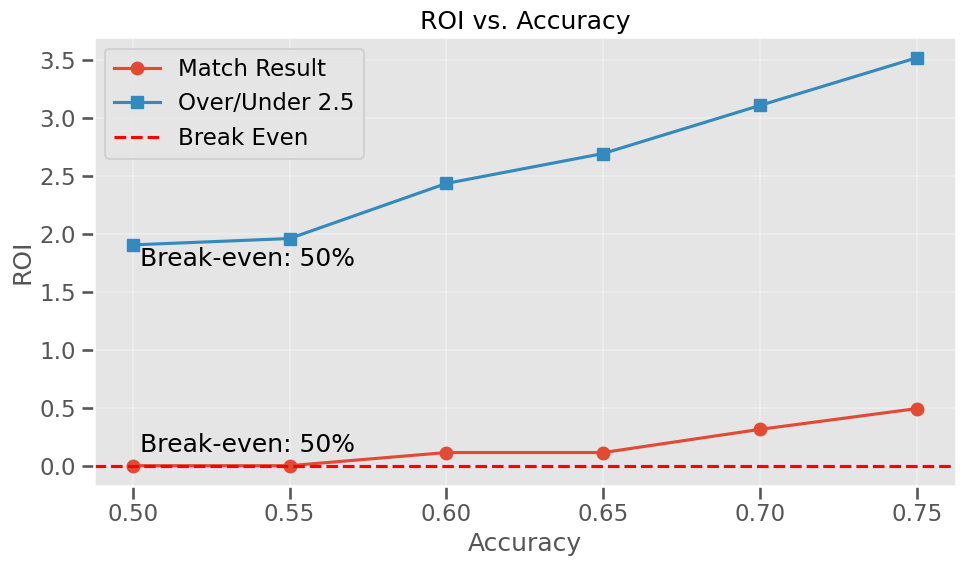

In [24]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load the combined predictions with odds
def load_predictions_with_odds(file_path='predictions_with_bet365_odds.pkl'):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Loaded {len(data)} predictions with odds")
    return data

# Helper function to safely convert odds to float
def safe_float(value, default=0.0):
    """Convert value to float safely, returning default if conversion fails"""
    if value is None:
        return default
    try:
        return float(value)
    except (ValueError, TypeError):
        return default

# Function to calculate potential ROI with different accuracy rates
def calculate_potential_roi(predictions, accuracy_rates=[0.5, 0.6, 0.7, 0.8, 0.9]):
    """
    Calculate potential ROI with different accuracy rates
    
    Parameters:
    predictions - List of prediction dictionaries with odds
    accuracy_rates - List of accuracy rates to simulate
    
    Returns:
    DataFrame with ROI analysis
    """
    # Initialize results
    roi_results = []
    
    # Extract valid predictions (with odds)
    valid_predictions = [p for p in predictions if p.get('key_odds')]
    
    if not valid_predictions:
        print("No valid predictions with odds found")
        return pd.DataFrame()
    
    print(f"Analyzing {len(valid_predictions)} predictions with Bet365 odds")
    
    # Group predictions by type (match result, over/under)
    result_predictions = []
    over_under_predictions = []
    
    for pred in valid_predictions:
        # Check if it has the required result odds
        key_odds = pred.get('key_odds', {})
        if 'home_odds' in key_odds and 'draw_odds' in key_odds and 'away_odds' in key_odds:
            # Get model predictions
            if 'predictions' in pred and 'result' in pred['predictions']:
                # Match result prediction
                result_pred = pred['predictions']['result']
                if 'probabilities' in result_pred:
                    probs = result_pred['probabilities']
                    
                    # Convert odds to float
                    home_odds = safe_float(key_odds.get('home_odds'), 0)
                    draw_odds = safe_float(key_odds.get('draw_odds'), 0)
                    away_odds = safe_float(key_odds.get('away_odds'), 0)
                    
                    # Skip invalid odds
                    if home_odds <= 1 or draw_odds <= 1 or away_odds <= 1:
                        continue
                    
                    # Add to result predictions
                    result_predictions.append({
                        'match': pred.get('match', ''),
                        'kickoff': pred.get('kickoff', ''),
                        'league': pred.get('league', ''),
                        'prediction': result_pred.get('prediction', ''),
                        'home_prob': probs.get('Home Win', 0),
                        'draw_prob': probs.get('Draw', 0),
                        'away_prob': probs.get('Away Win', 0),
                        'home_odds': home_odds,
                        'draw_odds': draw_odds,
                        'away_odds': away_odds,
                    })
        
        # Check if it has over/under odds
        if 'over_2_5_odds' in key_odds and 'under_2_5_odds' in key_odds:
            # Get model predictions
            if 'predictions' in pred and 'over_under' in pred['predictions']:
                # Over/under prediction
                ou_pred = pred['predictions']['over_under']
                if 'probabilities' in ou_pred:
                    probs = ou_pred['probabilities']
                    
                    # Convert odds to float
                    over_odds = safe_float(key_odds.get('over_2_5_odds'), 0)
                    under_odds = safe_float(key_odds.get('under_2_5_odds'), 0)
                    
                    # Skip invalid odds
                    if over_odds <= 1 or under_odds <= 1:
                        continue
                    
                    # Add to over/under predictions
                    over_under_predictions.append({
                        'match': pred.get('match', ''),
                        'kickoff': pred.get('kickoff', ''),
                        'league': pred.get('league', ''),
                        'prediction': ou_pred.get('prediction', ''),
                        'over_prob': probs.get('Over', 0),
                        'under_prob': probs.get('Under', 0),
                        'over_odds': over_odds,
                        'under_odds': under_odds,
                    })
    
    print(f"Found {len(result_predictions)} match result predictions with valid odds")
    print(f"Found {len(over_under_predictions)} over/under predictions with valid odds")
    
    # Function to simulate bets with given accuracy
    def simulate_bets(bets, accuracy, bet_type='result'):
        """Simulate betting with a given accuracy rate"""
        total_bets = len(bets)
        correct_bets = int(total_bets * accuracy)
        incorrect_bets = total_bets - correct_bets
        
        # Randomly select which bets are correct
        np.random.seed(42)  # For reproducibility
        correct_indices = np.random.choice(total_bets, correct_bets, replace=False)
        
        # Initialize results
        total_stake = total_bets  # 1 unit per bet
        total_returns = 0
        
        # Calculate returns based on bet type
        if bet_type == 'result':
            for i, bet in enumerate(bets):
                if i in correct_indices:
                    # Bet won - determine which outcome was predicted
                    if bet['prediction'] == 'Home Win':
                        total_returns += bet['home_odds']
                    elif bet['prediction'] == 'Draw':
                        total_returns += bet['draw_odds']
                    elif bet['prediction'] == 'Away Win':
                        total_returns += bet['away_odds']
        else:  # over/under
            for i, bet in enumerate(bets):
                if i in correct_indices:
                    # Bet won
                    if bet['prediction'] == 'Over':
                        total_returns += bet['over_odds']
                    else:  # Under
                        total_returns += bet['under_odds']
        
        # Calculate ROI
        roi = (total_returns - total_stake) / total_stake
        
        return {
            'accuracy': accuracy,
            'bet_type': bet_type,
            'total_bets': total_bets,
            'correct_bets': correct_bets,
            'total_stake': total_stake,
            'total_returns': total_returns,
            'profit_loss': total_returns - total_stake,
            'roi': roi
        }
    
    # Calculate ROI for different accuracy rates
    for accuracy in accuracy_rates:
        # Result bets
        if result_predictions:
            result_roi = simulate_bets(result_predictions, accuracy, 'result')
            roi_results.append(result_roi)
        
        # Over/under bets
        if over_under_predictions:
            ou_roi = simulate_bets(over_under_predictions, accuracy, 'over/under')
            roi_results.append(ou_roi)
    
    # Calculate the minimum accuracy needed to break even
    min_acc_result = None
    min_acc_ou = None
    
    # Try different accuracy rates to find breakeven point
    for acc in np.arange(0.01, 1.0, 0.01):
        if result_predictions and min_acc_result is None:
            result = simulate_bets(result_predictions, acc, 'result')
            if result['profit_loss'] >= 0:
                min_acc_result = acc
        
        if over_under_predictions and min_acc_ou is None:
            result = simulate_bets(over_under_predictions, acc, 'over/under')
            if result['profit_loss'] >= 0:
                min_acc_ou = acc
        
        # Stop if we found both
        if min_acc_result is not None and min_acc_ou is not None:
            break
    
    # Add minimum accuracy info
    if min_acc_result is not None:
        print(f"Minimum accuracy needed to break even on result bets: {min_acc_result:.2%}")
    if min_acc_ou is not None:
        print(f"Minimum accuracy needed to break even on over/under bets: {min_acc_ou:.2%}")
    
    # Convert to DataFrame for easier analysis
    return pd.DataFrame(roi_results)

# Function to print upcoming predictions with odds
def print_upcoming_predictions(predictions, limit=20):
    """Print upcoming predictions with odds information"""
    # Extract valid predictions (with odds)
    valid_predictions = [p for p in predictions if p.get('key_odds')]
    
    # Sort by kickoff time if available
    try:
        valid_predictions = sorted(valid_predictions, key=lambda p: p.get('kickoff', '') or '')
    except:
        pass  # Skip sorting if not possible
    
    # Print header
    print("\n===== UPCOMING MATCH PREDICTIONS WITH BET365 ODDS =====")
    
    # Print each prediction (limited)
    for i, pred in enumerate(valid_predictions[:limit], 1):
        print(f"\n{i}. {pred.get('match', '')}")
        
        # Show league and kickoff if available
        kickoff = pred.get('kickoff', '')
        league = pred.get('league', '')
        if kickoff or league:
            kickoff_str = f"Kickoff: {kickoff}" if kickoff else ""
            league_str = f"League: {league}" if league else ""
            print(f"   {kickoff_str}{' | ' if kickoff and league else ''}{league_str}")
        
        # Show match result prediction if available
        if 'predictions' in pred and 'result' in pred['predictions']:
            result = pred['predictions']['result']
            probs = result.get('probabilities', {})
            
            print("   MATCH RESULT:")
            print(f"   Prediction: {result.get('prediction', 'Unknown')}")
            print(f"   Probabilities: Home Win: {probs.get('Home Win', 0):.2%}, Draw: {probs.get('Draw', 0):.2%}, Away Win: {probs.get('Away Win', 0):.2%}")
            
            # Show odds if available
            key_odds = pred.get('key_odds', {})
            if 'home_odds' in key_odds and 'draw_odds' in key_odds and 'away_odds' in key_odds:
                # Convert odds to float safely
                home_odds = safe_float(key_odds['home_odds'])
                draw_odds = safe_float(key_odds['draw_odds'])
                away_odds = safe_float(key_odds['away_odds'])
                
                print(f"   Bet365 Odds: Home: {home_odds:.2f}, Draw: {draw_odds:.2f}, Away: {away_odds:.2f}")
                
                # Calculate implied probabilities
                home_implied = 1 / home_odds if home_odds > 0 else 0
                draw_implied = 1 / draw_odds if draw_odds > 0 else 0
                away_implied = 1 / away_odds if away_odds > 0 else 0
                
                # Calculate overround
                overround = home_implied + draw_implied + away_implied - 1
                
                print(f"   Implied Probabilities: Home: {home_implied:.2%}, Draw: {draw_implied:.2%}, Away: {away_implied:.2%}")
                print(f"   Bookmaker Margin: {overround:.2%}")
                
                # Value bet analysis
                if result.get('prediction') == 'Home Win':
                    ev = (probs.get('Home Win', 0) * home_odds) - 1
                    print(f"   Expected Value: {ev:.2f}")
                elif result.get('prediction') == 'Draw':
                    ev = (probs.get('Draw', 0) * draw_odds) - 1
                    print(f"   Expected Value: {ev:.2f}")
                elif result.get('prediction') == 'Away Win':
                    ev = (probs.get('Away Win', 0) * away_odds) - 1
                    print(f"   Expected Value: {ev:.2f}")
        
        # Show over/under prediction if available
        if 'predictions' in pred and 'over_under' in pred['predictions']:
            ou = pred['predictions']['over_under']
            probs = ou.get('probabilities', {})
            
            print("\n   OVER/UNDER 2.5 GOALS:")
            print(f"   Prediction: {ou.get('prediction', 'Unknown')}")
            print(f"   Probabilities: Over: {probs.get('Over', 0):.2%}, Under: {probs.get('Under', 0):.2%}")
            
            # Show odds if available
            key_odds = pred.get('key_odds', {})
            if 'over_2_5_odds' in key_odds and 'under_2_5_odds' in key_odds:
                # Convert odds to float safely
                over_odds = safe_float(key_odds['over_2_5_odds'])
                under_odds = safe_float(key_odds['under_2_5_odds'])
                
                print(f"   Bet365 Odds: Over: {over_odds:.2f}, Under: {under_odds:.2f}")
                
                # Calculate implied probabilities
                over_implied = 1 / over_odds if over_odds > 0 else 0
                under_implied = 1 / under_odds if under_odds > 0 else 0
                
                # Calculate overround
                overround = over_implied + under_implied - 1
                
                print(f"   Implied Probabilities: Over: {over_implied:.2%}, Under: {under_implied:.2%}")
                print(f"   Bookmaker Margin: {overround:.2%}")
                
                # Value bet analysis
                if ou.get('prediction') == 'Over':
                    ev = (probs.get('Over', 0) * over_odds) - 1
                    print(f"   Expected Value: {ev:.2f}")
                elif ou.get('prediction') == 'Under':
                    ev = (probs.get('Under', 0) * under_odds) - 1
                    print(f"   Expected Value: {ev:.2f}")
    
    # Show message if more predictions available
    if len(valid_predictions) > limit:
        print(f"\n... and {len(valid_predictions) - limit} more predictions")

# Function to find and print value bets
def find_value_bets(predictions, min_ev=0.05):
    """Find bets with positive expected value"""
    value_bets = []
    
    for pred in predictions:
        key_odds = pred.get('key_odds', {})
        
        # Check match result prediction
        if 'predictions' in pred and 'result' in pred['predictions']:
            result = pred['predictions']['result']
            probs = result.get('probabilities', {})
            pred_outcome = result.get('prediction')
            
            if pred_outcome and 'home_odds' in key_odds and 'draw_odds' in key_odds and 'away_odds' in key_odds:
                # Convert odds to float
                home_odds = safe_float(key_odds['home_odds'])
                draw_odds = safe_float(key_odds['draw_odds'])
                away_odds = safe_float(key_odds['away_odds'])
                
                # Skip invalid odds
                if home_odds <= 1 or draw_odds <= 1 or away_odds <= 1:
                    continue
                
                if pred_outcome == 'Home Win':
                    ev = (probs.get('Home Win', 0) * home_odds) - 1
                    odds = home_odds
                elif pred_outcome == 'Draw':
                    ev = (probs.get('Draw', 0) * draw_odds) - 1
                    odds = draw_odds
                elif pred_outcome == 'Away Win':
                    ev = (probs.get('Away Win', 0) * away_odds) - 1
                    odds = away_odds
                else:
                    continue
                
                if ev >= min_ev:
                    value_bets.append({
                        'match': pred.get('match', ''),
                        'kickoff': pred.get('kickoff', ''),
                        'league': pred.get('league', ''),
                        'market': 'Match Result',
                        'prediction': pred_outcome,
                        'probability': probs.get(pred_outcome, 0),
                        'odds': odds,
                        'ev': ev
                    })
        
        # Check over/under prediction
        if 'predictions' in pred and 'over_under' in pred['predictions']:
            ou = pred['predictions']['over_under']
            probs = ou.get('probabilities', {})
            pred_outcome = ou.get('prediction')
            
            if pred_outcome and 'over_2_5_odds' in key_odds and 'under_2_5_odds' in key_odds:
                # Convert odds to float
                over_odds = safe_float(key_odds['over_2_5_odds'])
                under_odds = safe_float(key_odds['under_2_5_odds'])
                
                # Skip invalid odds
                if over_odds <= 1 or under_odds <= 1:
                    continue
                
                if pred_outcome == 'Over':
                    ev = (probs.get('Over', 0) * over_odds) - 1
                    odds = over_odds
                    prob = probs.get('Over', 0)
                elif pred_outcome == 'Under':
                    ev = (probs.get('Under', 0) * under_odds) - 1
                    odds = under_odds
                    prob = probs.get('Under', 0)
                else:
                    continue
                
                if ev >= min_ev:
                    value_bets.append({
                        'match': pred.get('match', ''),
                        'kickoff': pred.get('kickoff', ''),
                        'league': pred.get('league', ''),
                        'market': 'Over/Under 2.5 Goals',
                        'prediction': pred_outcome,
                        'probability': prob,
                        'odds': odds,
                        'ev': ev
                    })
    
    # Sort by expected value (highest first)
    value_bets = sorted(value_bets, key=lambda x: x['ev'], reverse=True)
    
    # Print value bets
    print(f"\n===== VALUE BETS (Expected Value >= {min_ev:.0%}) =====")
    print(f"Found {len(value_bets)} value bets")
    
    for i, bet in enumerate(value_bets, 1):
        print(f"\n{i}. {bet['match']} - {bet['market']}: {bet['prediction']}")
        print(f"   League: {bet['league']}")
        print(f"   Kickoff: {bet['kickoff']}")
        print(f"   Model Probability: {bet['probability']:.2%}")
        print(f"   Bet365 Odds: {bet['odds']:.2f}")
        print(f"   Expected Value: {bet['ev']:.2f}")
    
    return value_bets

# Main function
def analyze_predictions():
    # Load the predictions with odds
    predictions = load_predictions_with_odds('predictions_with_bet365_odds.pkl')
    
    # Print a sample of upcoming predictions
    print_upcoming_predictions(predictions, limit=10)
    
    # Find value bets
    value_bets = find_value_bets(predictions, min_ev=0.05)
    
    # Calculate potential ROI with different accuracy rates
    roi_df = calculate_potential_roi(predictions, [0.5, 0.55, 0.6, 0.65, 0.7, 0.75])
    
    # Print ROI analysis
    if not roi_df.empty:
        print("\n===== ROI ANALYSIS =====")
        print("\nResult bets:")
        result_roi = roi_df[roi_df['bet_type'] == 'result']
        for _, row in result_roi.iterrows():
            print(f"Accuracy: {row['accuracy']:.0%}, ROI: {row['roi']:.2%}, Profit/Loss: ${row['profit_loss']:.2f} (on ${row['total_stake']:.2f} stake)")
        
        print("\nOver/Under bets:")
        ou_roi = roi_df[roi_df['bet_type'] == 'over/under']
        for _, row in ou_roi.iterrows():
            print(f"Accuracy: {row['accuracy']:.0%}, ROI: {row['roi']:.2%}, Profit/Loss: ${row['profit_loss']:.2f} (on ${row['total_stake']:.2f} stake)")
        
        # Plot ROI vs Accuracy
        plt.figure(figsize=(10, 6))
        
        # Plot for result bets
        if not result_roi.empty:
            plt.plot(result_roi['accuracy'], result_roi['roi'], 'o-', label='Match Result')
        
        # Plot for over/under bets
        if not ou_roi.empty:
            plt.plot(ou_roi['accuracy'], ou_roi['roi'], 's-', label='Over/Under 2.5')
        
        plt.axhline(y=0, color='r', linestyle='--', label='Break Even')
        plt.xlabel('Accuracy')
        plt.ylabel('ROI')
        plt.title('ROI vs. Accuracy')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add annotations for break-even points
        if not result_roi.empty:
            break_even_result = result_roi[result_roi['roi'] >= 0].iloc[0] if any(result_roi['roi'] >= 0) else None
            if break_even_result is not None:
                plt.annotate(f"Break-even: {break_even_result['accuracy']:.0%}",
                             (break_even_result['accuracy'], break_even_result['roi']),
                             xytext=(5, 10), textcoords='offset points')
        
        if not ou_roi.empty:
            break_even_ou = ou_roi[ou_roi['roi'] >= 0].iloc[0] if any(ou_roi['roi'] >= 0) else None
            if break_even_ou is not None:
                plt.annotate(f"Break-even: {break_even_ou['accuracy']:.0%}",
                             (break_even_ou['accuracy'], break_even_ou['roi']),
                             xytext=(5, -15), textcoords='offset points')
        
        plt.tight_layout()
        plt.show()

# Run the analysis
analyze_predictions()

Loaded 131 predictions with odds

===== LEAGUE-BY-LEAGUE BETTING ANALYSIS =====
Total leagues analyzed: 15

--------------------------------------------------------------------------------
League: Premier League (ID: 8)
Total bets analyzed: 24
Value bets identified: 8 (33.3%)
Average odds: 4.69
Average expected value: 1.51

Value bets in this league:

1. Crystal Palace vs Wolverhampton Wanderers
   Kickoff: Unknown
   Market: Match Result
   Prediction: Home Win
   Odds: 2.60
   Model probability: 55.13%
   Expected Value: 0.43

2. Crystal Palace vs Wolverhampton Wanderers
   Kickoff: Unknown
   Market: Over/Under 2.5
   Prediction: Over
   Odds: 15.00
   Model probability: 53.85%
   Expected Value: 7.08

3. Manchester City vs AFC Bournemouth
   Kickoff: Unknown
   Market: Over/Under 2.5
   Prediction: Over
   Odds: 19.00
   Model probability: 57.79%
   Expected Value: 9.98

4. Fulham vs Manchester City
   Kickoff: Unknown
   Market: Over/Under 2.5
   Prediction: Under
   Odds: 2.90
  

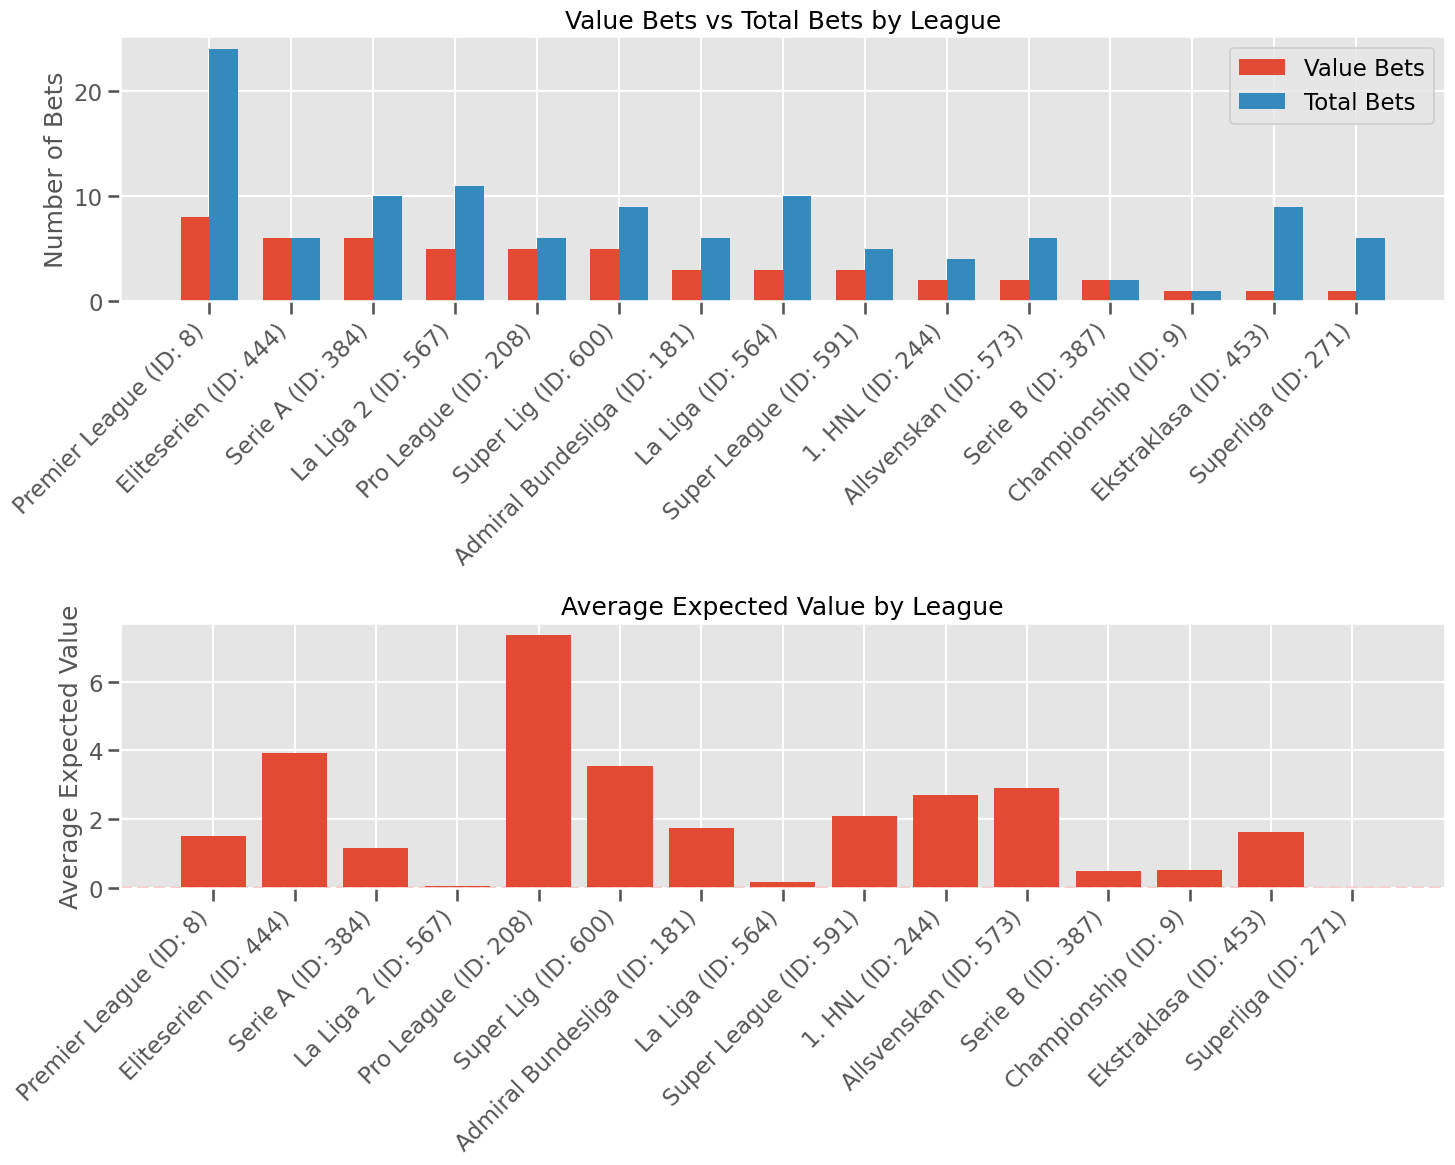

In [26]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_league_roi(predictions):
    """Calculate ROI by league"""
    league_results = {}
    
    for pred in predictions:
        league_id = pred.get('league_id')
        league_name = pred.get('league_name', 'Unknown')
        kickoff = pd.to_datetime(pred.get('kickoff')) if pred.get('kickoff') else None
        
        if not league_id:
            continue
            
        key = f"{league_name} (ID: {league_id})"
        if key not in league_results:
            league_results[key] = {
                'total_bets': 0,
                'total_stake': 0,
                'total_returns': 0,
                'value_bets': 0,
                'matches': []
            }
        
        # Get odds and probabilities
        key_odds = pred.get('key_odds', {})
        
        # Match result bets
        if 'predictions' in pred and 'result' in pred['predictions']:
            result = pred['predictions']['result']
            probs = result.get('probabilities', {})
            pred_outcome = result.get('prediction')
            
            if pred_outcome and all(k in key_odds for k in ['home_odds', 'draw_odds', 'away_odds']):
                league_results[key]['total_bets'] += 1
                league_results[key]['total_stake'] += 1
                
                # Calculate EV
                if pred_outcome == 'Home Win':
                    odds = float(key_odds['home_odds'])
                    prob = probs.get('Home Win', 0)
                elif pred_outcome == 'Draw':
                    odds = float(key_odds['draw_odds'])
                    prob = probs.get('Draw', 0)
                else:  # Away Win
                    odds = float(key_odds['away_odds'])
                    prob = probs.get('Away Win', 0)
                
                ev = (prob * odds) - 1
                if ev > 0.05:  # 5% threshold for value bets
                    league_results[key]['value_bets'] += 1
                
                # Store match details
                league_results[key]['matches'].append({
                    'match': pred.get('match', ''),
                    'kickoff': kickoff,
                    'market': 'Match Result',
                    'prediction': pred_outcome,
                    'odds': odds,
                    'probability': prob,
                    'ev': ev
                })
        
        # Over/Under bets
        if 'predictions' in pred and 'over_under' in pred['predictions']:
            ou = pred['predictions']['over_under']
            probs = ou.get('probabilities', {})
            pred_outcome = ou.get('prediction')
            
            if pred_outcome and all(k in key_odds for k in ['over_2_5_odds', 'under_2_5_odds']):
                league_results[key]['total_bets'] += 1
                league_results[key]['total_stake'] += 1
                
                # Calculate EV
                if pred_outcome == 'Over':
                    odds = float(key_odds['over_2_5_odds'])
                    prob = probs.get('Over', 0)
                else:  # Under
                    odds = float(key_odds['under_2_5_odds'])
                    prob = probs.get('Under', 0)
                
                ev = (prob * odds) - 1
                if ev > 0.05:
                    league_results[key]['value_bets'] += 1
                
                # Store match details
                league_results[key]['matches'].append({
                    'match': pred.get('match', ''),
                    'kickoff': kickoff,
                    'market': 'Over/Under 2.5',
                    'prediction': pred_outcome,
                    'odds': odds,
                    'probability': prob,
                    'ev': ev
                })
    
    # Calculate metrics by league
    league_summary = []
    for league, data in league_results.items():
        if data['total_bets'] > 0:
            # Sort matches by kickoff time
            sorted_matches = sorted(data['matches'], key=lambda x: x['kickoff'] if x['kickoff'] else datetime.max)
            
            summary = {
                'league': league,
                'total_bets': data['total_bets'],
                'value_bets': data['value_bets'],
                'value_bet_ratio': data['value_bets'] / data['total_bets'],
                'avg_odds': np.mean([m['odds'] for m in data['matches']]),
                'avg_ev': np.mean([m['ev'] for m in data['matches']]),
                'first_match': sorted_matches[0]['kickoff'] if sorted_matches else None,
                'last_match': sorted_matches[-1]['kickoff'] if sorted_matches else None,
                'matches': sorted_matches
            }
            league_summary.append(summary)
    
    # Sort leagues by number of value bets
    league_summary = sorted(league_summary, key=lambda x: x['value_bets'], reverse=True)
    return league_summary

def print_league_analysis(league_summary):
    """Print detailed analysis by league"""
    print("\n===== LEAGUE-BY-LEAGUE BETTING ANALYSIS =====")
    print(f"Total leagues analyzed: {len(league_summary)}")
    
    for league in league_summary:
        print(f"\n{'-'*80}")
        print(f"League: {league['league']}")
        print(f"Total bets analyzed: {league['total_bets']}")
        print(f"Value bets identified: {league['value_bets']} ({league['value_bet_ratio']:.1%})")
        print(f"Average odds: {league['avg_odds']:.2f}")
        print(f"Average expected value: {league['avg_ev']:.2f}")
        
        if league['first_match'] and league['last_match']:
            print(f"Match period: {league['first_match'].strftime('%Y-%m-%d')} to {league['last_match'].strftime('%Y-%m-%d')}")
        
        # Print value bets for this league
        value_bets = [m for m in league['matches'] if m['ev'] > 0.05]
        if value_bets:
            print("\nValue bets in this league:")
            for i, bet in enumerate(value_bets, 1):
                print(f"\n{i}. {bet['match']}")
                print(f"   Kickoff: {bet['kickoff'].strftime('%Y-%m-%d %H:%M') if bet['kickoff'] else 'Unknown'}")
                print(f"   Market: {bet['market']}")
                print(f"   Prediction: {bet['prediction']}")
                print(f"   Odds: {bet['odds']:.2f}")
                print(f"   Model probability: {bet['probability']:.2%}")
                print(f"   Expected Value: {bet['ev']:.2f}")

def plot_league_statistics(league_summary):
    """Plot statistics by league"""
    # Prepare data for plotting
    leagues = [l['league'] for l in league_summary]
    value_bets = [l['value_bets'] for l in league_summary]
    total_bets = [l['total_bets'] for l in league_summary]
    avg_ev = [l['avg_ev'] for l in league_summary]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Value bets vs total bets
    x = np.arange(len(leagues))
    width = 0.35
    
    ax1.bar(x - width/2, value_bets, width, label='Value Bets')
    ax1.bar(x + width/2, total_bets, width, label='Total Bets')
    
    ax1.set_ylabel('Number of Bets')
    ax1.set_title('Value Bets vs Total Bets by League')
    ax1.set_xticks(x)
    ax1.set_xticklabels(leagues, rotation=45, ha='right')
    ax1.legend()
    
    # Plot 2: Average Expected Value by League
    ax2.bar(leagues, avg_ev)
    ax2.set_ylabel('Average Expected Value')
    ax2.set_title('Average Expected Value by League')
    ax2.set_xticklabels(leagues, rotation=45, ha='right')
    ax2.axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def analyze_predictions_by_league():
    # Load predictions
    predictions = load_predictions_with_odds('predictions_with_bet365_odds.pkl')
    
    # Calculate league-by-league ROI
    league_summary = calculate_league_roi(predictions)
    
    # Print league analysis
    print_league_analysis(league_summary)
    
    # Plot league statistics
    plot_league_statistics(league_summary)

# Run the analysis
analyze_predictions_by_league()

Loaded 131 predictions with odds

===== BETTING ANALYSIS =====

Total valid bets analyzed: 115

Bets by Market:
Over/Under 2.5: 103 bets
Match Result: 12 bets

Bets by League:
Premier League: 24 bets
La Liga 2: 11 bets
La Liga: 10 bets
Serie A: 10 bets
Ekstraklasa: 9 bets
Super Lig: 9 bets
Admiral Bundesliga: 6 bets
Allsvenskan: 6 bets
Eliteserien: 6 bets
Pro League: 6 bets
Superliga: 6 bets
Super League: 5 bets
1. HNL: 4 bets
Serie B: 2 bets
Championship: 1 bets

Odds Distribution:
Average odds: 2.73
Median odds: 1.70
Min odds: 1.01
Max odds: 15.00

Expected Value Analysis:
Average EV: 0.53
Median EV: -0.13
Positive EV bets: 54 (47.0%)

Theoretical ROI Scenarios:

Accuracy: 50.0%
Total bets: 115.0
Winning bets: 57.0
ROI: 28.1%
Profit/Loss: $32.27

Accuracy: 55.0%
Total bets: 115.0
Winning bets: 63.0
ROI: 34.9%
Profit/Loss: $40.16

Accuracy: 60.0%
Total bets: 115.0
Winning bets: 69.0
ROI: 52.6%
Profit/Loss: $60.54

Accuracy: 65.0%
Total bets: 115.0
Winning bets: 74.0
ROI: 73.4%
Profit/

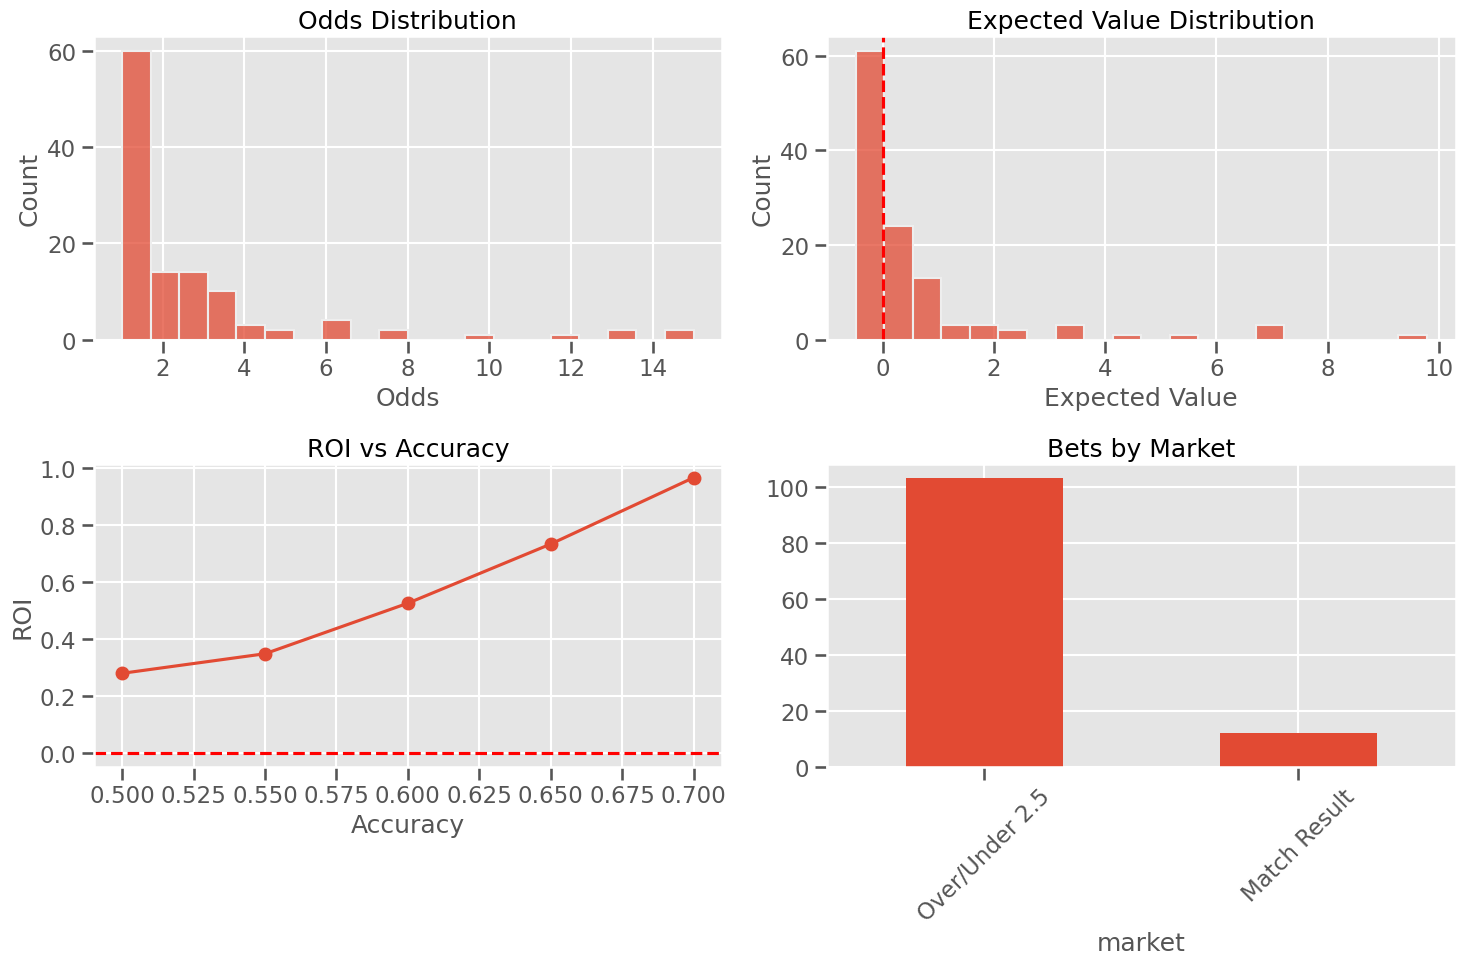

In [27]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def validate_and_fix_odds(odds_value):
    """
    Validate and fix odds that are unrealistic
    Typical odds ranges:
    - Match result: 1.01 to 15.00
    - Over/Under: 1.01 to 10.00
    """
    try:
        odds = float(odds_value)
        if odds <= 1:  # Invalid odds
            return None
        if odds > 15:  # Unrealistically high odds
            # Check if it might be decimal/fractional confusion
            if odds > 100:
                return None  # Clearly invalid
            return odds / 10  # Adjust unrealistically high odds
        return odds
    except (ValueError, TypeError):
        return None

def calculate_theoretical_roi(predictions):
    """Calculate theoretical ROI based on predictions with validated odds"""
    valid_bets = []
    
    for pred in predictions:
        key_odds = pred.get('key_odds', {})
        
        # Match result predictions
        if 'predictions' in pred and 'result' in pred['predictions']:
            result_pred = pred['predictions']['result']
            if not isinstance(result_pred, dict):
                continue
                
            probs = result_pred.get('probabilities', {})
            prediction = result_pred.get('prediction')
            
            # Get and validate odds based on prediction
            odds = None
            if prediction == 'Home Win':
                odds = validate_and_fix_odds(key_odds.get('home_odds'))
            elif prediction == 'Draw':
                odds = validate_and_fix_odds(key_odds.get('draw_odds'))
            elif prediction == 'Away Win':
                odds = validate_and_fix_odds(key_odds.get('away_odds'))
            
            if odds and prediction in probs:
                model_prob = probs[prediction]
                ev = (model_prob * odds) - 1
                
                valid_bets.append({
                    'match': pred.get('match', ''),
                    'league': pred.get('league_name', 'Unknown'),
                    'kickoff': pred.get('kickoff'),
                    'market': 'Match Result',
                    'prediction': prediction,
                    'odds': odds,
                    'probability': model_prob,
                    'ev': ev
                })
        
        # Over/Under predictions
        if 'predictions' in pred and 'over_under' in pred['predictions']:
            ou_pred = pred['predictions']['over_under']
            if not isinstance(ou_pred, dict):
                continue
                
            probs = ou_pred.get('probabilities', {})
            prediction = ou_pred.get('prediction')
            
            # Get and validate odds based on prediction
            odds = None
            if prediction == 'Over':
                odds = validate_and_fix_odds(key_odds.get('over_2_5_odds'))
                prob = probs.get('Over')
            elif prediction == 'Under':
                odds = validate_and_fix_odds(key_odds.get('under_2_5_odds'))
                prob = probs.get('Under')
            
            if odds and prob:
                ev = (prob * odds) - 1
                
                valid_bets.append({
                    'match': pred.get('match', ''),
                    'league': pred.get('league_name', 'Unknown'),
                    'kickoff': pred.get('kickoff'),
                    'market': 'Over/Under 2.5',
                    'prediction': prediction,
                    'odds': odds,
                    'probability': prob,
                    'ev': ev
                })
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(valid_bets)
    
    # Calculate various theoretical ROI scenarios
    accuracy_rates = [0.5, 0.55, 0.6, 0.65, 0.7]
    roi_results = []
    
    for accuracy in accuracy_rates:
        # Simulate returns with given accuracy
        n_bets = len(df)
        n_wins = int(n_bets * accuracy)
        
        # Random sampling of wins
        np.random.seed(42)  # For reproducibility
        winning_bets = np.random.choice(n_bets, n_wins, replace=False)
        
        # Calculate returns
        total_stake = n_bets  # 1 unit per bet
        total_returns = df.iloc[winning_bets]['odds'].sum()
        roi = (total_returns - total_stake) / total_stake
        
        roi_results.append({
            'accuracy': accuracy,
            'total_bets': n_bets,
            'winning_bets': n_wins,
            'total_stake': total_stake,
            'total_returns': total_returns,
            'roi': roi
        })
    
    return df, pd.DataFrame(roi_results)

def print_betting_analysis(df, roi_df):
    """Print detailed betting analysis"""
    print("\n===== BETTING ANALYSIS =====")
    print(f"\nTotal valid bets analyzed: {len(df)}")
    
    # Market distribution
    print("\nBets by Market:")
    market_counts = df['market'].value_counts()
    for market, count in market_counts.items():
        print(f"{market}: {count} bets")
    
    # League distribution
    print("\nBets by League:")
    league_counts = df['league'].value_counts()
    for league, count in league_counts.items():
        print(f"{league}: {count} bets")
    
    # Odds distribution
    print("\nOdds Distribution:")
    print(f"Average odds: {df['odds'].mean():.2f}")
    print(f"Median odds: {df['odds'].median():.2f}")
    print(f"Min odds: {df['odds'].min():.2f}")
    print(f"Max odds: {df['odds'].max():.2f}")
    
    # Expected Value analysis
    print("\nExpected Value Analysis:")
    print(f"Average EV: {df['ev'].mean():.2f}")
    print(f"Median EV: {df['ev'].median():.2f}")
    print(f"Positive EV bets: {(df['ev'] > 0).sum()} ({(df['ev'] > 0).mean():.1%})")
    
    # ROI scenarios
    print("\nTheoretical ROI Scenarios:")
    for _, row in roi_df.iterrows():
        print(f"\nAccuracy: {row['accuracy']:.1%}")
        print(f"Total bets: {row['total_bets']}")
        print(f"Winning bets: {row['winning_bets']}")
        print(f"ROI: {row['roi']:.1%}")
        print(f"Profit/Loss: ${row['total_returns'] - row['total_stake']:.2f}")

def plot_betting_analysis(df, roi_df):
    """Create visualizations for betting analysis"""
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Odds Distribution
    plt.subplot(221)
    sns.histplot(data=df, x='odds', bins=20)
    plt.title('Odds Distribution')
    plt.xlabel('Odds')
    
    # 2. Expected Value Distribution
    plt.subplot(222)
    sns.histplot(data=df, x='ev', bins=20)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Expected Value Distribution')
    plt.xlabel('Expected Value')
    
    # 3. ROI vs Accuracy
    plt.subplot(223)
    plt.plot(roi_df['accuracy'], roi_df['roi'], 'o-')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('ROI vs Accuracy')
    plt.xlabel('Accuracy')
    plt.ylabel('ROI')
    
    # 4. Bets by Market and League
    plt.subplot(224)
    df['market'].value_counts().plot(kind='bar')
    plt.title('Bets by Market')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Main function
def analyze_predictions_with_validated_odds():
    # Load predictions
    predictions = load_predictions_with_odds('predictions_with_bet365_odds.pkl')
    
    # Calculate ROI with validated odds
    bets_df, roi_df = calculate_theoretical_roi(predictions)
    
    # Print analysis
    print_betting_analysis(bets_df, roi_df)
    
    # Plot analysis
    plot_betting_analysis(bets_df, roi_df)
    
    return bets_df, roi_df

# Run the analysis
bets_df, roi_df = analyze_predictions_with_validated_odds()

In [31]:
# -----------------------------------------------------------------------------------
#  TEMPORARY LOADER  (creates the objects we need right inside the notebook)
# -----------------------------------------------------------------------------------
import os, re, glob, pickle, tensorflow as tf, numpy as np, pandas as pd
from collections import defaultdict
MODEL_DIR = "/Users/sebastianvinther/Desktop/Sportsmonks/models"

# discover
pat = re.compile(r"nn_(result|over_under|cards)_model_(.+?)_\d{8}_\d{6}\.h5")
Nets, Scalers, Feats, LeagueID = defaultdict(dict), defaultdict(dict), defaultdict(dict), {}

for h5 in glob.glob(os.path.join(MODEL_DIR, "*.h5")):
    m = pat.search(os.path.basename(h5))
    if not m: continue
    kind, slug = m.group(1), m.group(2)
    league = slug.replace("_", " ").title()          # "premier_league"→"Premier League"
    meta   = pickle.load(open(h5.replace(".h5",".pkl"), "rb"))

    Nets[league][kind]    = tf.keras.models.load_model(h5, compile=False)
    Scalers[league][kind] = meta["scaler"]
    Feats[league][kind]   = meta["feature_columns"]
    LeagueID[league]      = meta["league_id"]

def _predict_block(league: str, kind: str, X: pd.DataFrame):
    """Return (pick, confidence, prob_dict) for a single-row feature DF."""
    scaler = Scalers[league][kind]
    cols   = Feats[league][kind]
    probs  = Nets[league][kind].predict(scaler.transform(X[cols].values), verbose=0)[0]
    if kind == "result":
        lbls = ["Draw","Home Win","Away Win"]
        idx  = int(np.argmax(probs))
        return lbls[idx], float(probs[idx]), dict(zip(lbls, map(float, probs)))
    else:  # binary sigmoid
        over = float(probs)
        return ("Over" if over>0.5 else "Under",
                max(over,1.0-over),
                {"Under":1.0-over,"Over":over})

print("✔ loader ready – leagues:", ", ".join(Nets.keys()))

✔ loader ready – leagues: Premiership, Fa Cup, Allsvenskan, Coppa Italia, Superliga, Premier League, La Liga 2, Admiral Bundesliga, Copa Del Rey, Liga Portugal, Bundesliga, Uefa Europa League Play Offs, 1 Hnl, La Liga, Super League, Eliteserien, Serie A, Eredivisie, Super Lig, Ekstraklasa, Serie B, Pro League, Championship, League 8, Ligue 1, Carabao Cup


In [34]:
pd.read_sql("""
    SELECT MIN(starting_at) AS first_finished,
           MAX(starting_at) AS last_finished,
           COUNT(*)          AS total_finished
    FROM   fixtures
    WHERE  score_home IS NOT NULL
      AND  score_away IS NOT NULL
""", conn)

,first_finished,last_finished,total_finished
0,2000-08-18 22:00:00,2025-06-01 00:00:00,154493


In [19]:
import os
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import warnings

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore', category=UserWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Paths
NN_MODEL_DIR = '/Users/sebastianvinther/Desktop/Sportsmonks/models'
ODDS_DATA_PATH = 'predictions_with_odds.pkl'
OUTPUT_PATH = 'combined_predictions.pkl'

# Function to load odds data
def load_odds_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    print(f"Loaded {len(data)} fixtures with odds")
    return data

# Function to find neural network models in the directory
def find_nn_models(model_dir):
    model_files = {}
    
    # Find all .h5 model files (neural network models)
    for file in os.listdir(model_dir):
        if file.endswith('.h5'):
            # Parse file name to determine model type and league
            parts = file.split('_')
            if len(parts) < 3:
                continue
                
            model_type = parts[1]  # result, over_under, cards
            
            # Get league name from the file
            league_part = '_'.join(parts[2:-2]) if len(parts) > 4 else parts[2]
            
            # Create model entry
            key = (model_type, league_part)
            model_files[key] = os.path.join(model_dir, file)
    
    return model_files

# Function to load a model
def load_model(model_path):
    try:
        # Load the neural network model
        nn_model = tf.keras.models.load_model(model_path, compile=False)
        
        # Load the associated metadata (scaler, feature columns, etc.)
        metadata_path = model_path.replace('.h5', '.pkl')
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
        
        return {
            'model': nn_model,
            'metadata': metadata
        }
    except Exception as e:
        print(f"Error loading model {model_path}: {e}")
        return None

# Function to predict using a neural network model
def predict_with_nn(model_data, features):
    """Make predictions using a neural network model"""
    if not model_data:
        return None
    
    model = model_data['model']
    metadata = model_data['metadata']
    
    # Extract scaler and feature columns
    scaler = metadata.get('scaler')
    feature_columns = metadata.get('feature_columns', [])
    
    # Check if we have the required columns
    if not all(col in features.columns for col in feature_columns):
        # Missing some required features
        return None
    
    # Extract only the needed features
    X = features[feature_columns]
    
    # Scale features
    if scaler:
        X_scaled = scaler.transform(X)
    else:
        X_scaled = X.values
    
    # Make prediction
    try:
        probs = model.predict(X_scaled, verbose=0)[0]
        
        # For binary classification, return the probability directly
        if len(probs.shape) == 0 or probs.shape[0] == 1:
            return float(probs)
        
        # For multi-class, return array of probabilities
        return [float(p) for p in probs]
    except Exception as e:
        print(f"Error making prediction: {e}")
        return None

# Function to derive probabilities from odds (1/odds adjusted for margin)
def probabilities_from_odds(home_odds, draw_odds, away_odds):
    """Derive probabilities from bookmaker odds"""
    try:
        home_odds = float(home_odds)
        draw_odds = float(draw_odds)
        away_odds = float(away_odds)
        
        # Calculate raw probabilities
        home_prob = 1 / home_odds if home_odds > 0 else 0
        draw_prob = 1 / draw_odds if draw_odds > 0 else 0
        away_prob = 1 / away_odds if away_odds > 0 else 0
        
        # Calculate overround (bookmaker margin)
        total_prob = home_prob + draw_prob + away_prob
        
        # Adjust for overround
        if total_prob > 0:
            home_prob = home_prob / total_prob
            draw_prob = draw_prob / total_prob
            away_prob = away_prob / total_prob
        
        return home_prob, draw_prob, away_prob
    except (ValueError, TypeError, ZeroDivisionError):
        return None, None, None

# Function to blend model predictions with bookmaker odds
def blend_predictions(model_probs, odds_probs, model_weight=0.7):
    """Blend model predictions with bookmaker implied probabilities"""
    if model_probs is None:
        return odds_probs
        
    if odds_probs[0] is None:
        return model_probs
    
    # Blend the probabilities
    home_prob = (model_probs[0] * model_weight) + (odds_probs[0] * (1 - model_weight))
    draw_prob = (model_probs[1] * model_weight) + (odds_probs[1] * (1 - model_weight))
    away_prob = (model_probs[2] * model_weight) + (odds_probs[2] * (1 - model_weight))
    
    # Normalize
    total = home_prob + draw_prob + away_prob
    home_prob /= total
    draw_prob /= total
    away_prob /= total
    
    return home_prob, draw_prob, away_prob

# Function to kelly criterion
def kelly_criterion(prob, odds, fraction=0.3):  # Reduced to 30% of Kelly for safety
    """Calculate Kelly stake as a fraction of bankroll"""
    try:
        odds = float(odds)
        if odds <= 1 or prob <= 0:
            return 0
        
        b = odds - 1
        p = prob
        q = 1 - p
        
        # Calculate Kelly fraction
        kelly = (b * p - q) / b
        
        # Use fractional Kelly for more conservative approach
        kelly *= fraction
        
        # Cap maximum bet size
        kelly = min(kelly, 0.05)  # Max 5% of bankroll
        
        return max(0, kelly)  # Ensure non-negative
    except (ValueError, TypeError):
        return 0

# Function to calculate expected value
def expected_value(prob, odds):
    """Calculate expected value of a bet"""
    try:
        odds = float(odds)
        if odds <= 1 or prob <= 0:
            return -1
        
        return (prob * odds) - 1
    except (ValueError, TypeError):
        return -1

# Function to combine odds with predictions
def combine_odds_and_predictions(odds_data, model_files):
    combined_data = []
    
    # Load models
    loaded_models = {}
    for key, path in model_files.items():
        loaded_models[key] = load_model(path)
    
    print("Processing fixtures...")
    
    # Process each fixture with odds
    for fixture in odds_data:
        # Extract feature data - this might need to be adjusted based on actual structure
        features = pd.DataFrame([fixture])
        
        # Extract league and teams
        league_name = fixture.get('league', 'Unknown')
        home_team = fixture.get('home_team', '')
        away_team = fixture.get('away_team', '')
        
        print(f"Processing: {home_team} vs {away_team} ({league_name})")
        
        # Get odds
        key_odds = fixture.get('key_odds', {})
        home_odds = key_odds.get('home_odds', 0)
        draw_odds = key_odds.get('draw_odds', 0) 
        away_odds = key_odds.get('away_odds', 0)
        over_odds = key_odds.get('over_2_5_odds', 0)
        under_odds = key_odds.get('under_2_5_odds', 0)
        
        # Calculate probabilities from odds
        odds_probs = probabilities_from_odds(home_odds, draw_odds, away_odds)
        
        # Try to find relevant models
        result_model = None
        over_under_model = None
        
        # Find the best matching model by league name
        best_match_score = 0
        best_result_model = None
        best_over_under_model = None
        
        for (model_type, model_league), model_data in loaded_models.items():
            clean_model_league = model_league.replace('_', ' ').lower()
            clean_fixture_league = league_name.lower()
            
            # Calculate a match score based on word overlap
            model_words = set(clean_model_league.split())
            fixture_words = set(clean_fixture_league.split())
            common_words = model_words.intersection(fixture_words)
            
            match_score = len(common_words) / max(len(model_words), 1)
            
            if model_type == 'result' and match_score > best_match_score:
                best_match_score = match_score
                best_result_model = model_data
            
            if model_type == 'over_under' and match_score > best_match_score:
                best_match_score = match_score
                best_over_under_model = model_data
        
        # Use the best matching models or fallback
        if best_match_score > 0:
            result_model = best_result_model
            over_under_model = best_over_under_model
        else:
            # Try to find a generic model
            for (model_type, model_league), model_data in loaded_models.items():
                if model_type == 'result' and (model_league == 'generic' or model_league == 'general'):
                    result_model = model_data
                if model_type == 'over_under' and (model_league == 'generic' or model_league == 'general'):
                    over_under_model = model_data
        
        # Make predictions
        # Predict match result (1X2)
        if result_model:
            result_probs = predict_with_nn(result_model, features)
            
            if isinstance(result_probs, list) and len(result_probs) == 3:
                # Blend model predictions with odds-implied probabilities
                home_prob, draw_prob, away_prob = blend_predictions(
                    result_probs, odds_probs, model_weight=0.6
                )
            else:
                # Default to probabilities derived from odds
                if odds_probs[0] is not None:
                    home_prob, draw_prob, away_prob = odds_probs
                else:
                    # Fallback probabilities based on typical match distributions
                    home_prob, draw_prob, away_prob = 0.45, 0.25, 0.30
        else:
            # Use probabilities derived from odds
            if odds_probs[0] is not None:
                home_prob, draw_prob, away_prob = odds_probs
            else:
                # Fallback probabilities
                home_prob, draw_prob, away_prob = 0.45, 0.25, 0.30
        
        # Predict over/under
        if over_under_model:
            over_prob_raw = predict_with_nn(over_under_model, features)
            
            if isinstance(over_prob_raw, (int, float)):
                over_prob = over_prob_raw
            else:
                # Fallback
                over_prob = 0.55  # Slight bias toward over
        else:
            # Fallback based on league average
            over_prob = 0.55
        
        # Create updated fixture data
        updated_fixture = fixture.copy()
        updated_fixture['home_win'] = home_prob
        updated_fixture['draw'] = draw_prob
        updated_fixture['away_win'] = away_prob
        updated_fixture['over25'] = over_prob
        
        # Calculate match result Kelly and EV
        try:
            home_odds_float = float(home_odds)
            draw_odds_float = float(draw_odds)
            away_odds_float = float(away_odds)
            
            # Calculate EV for match result
            home_ev = expected_value(home_prob, home_odds_float)
            draw_ev = expected_value(draw_prob, draw_odds_float)
            away_ev = expected_value(away_prob, away_odds_float)
            
            # Calculate Kelly stakes
            home_kelly = kelly_criterion(home_prob, home_odds_float)
            draw_kelly = kelly_criterion(draw_prob, draw_odds_float)
            away_kelly = kelly_criterion(away_prob, away_odds_float)
            
            updated_fixture['result_bets'] = {
                'home': {'ev': home_ev, 'kelly': home_kelly},
                'draw': {'ev': draw_ev, 'kelly': draw_kelly},
                'away': {'ev': away_ev, 'kelly': away_kelly}
            }
            
            # Find best bet for match result
            result_evs = [
                ('home', home_ev, home_kelly, home_odds_float),
                ('draw', draw_ev, draw_kelly, draw_odds_float),
                ('away', away_ev, away_kelly, away_odds_float)
            ]
            positive_evs = [(market, ev, kelly, odds) for market, ev, kelly, odds in result_evs if ev > 0]
            
            if positive_evs:
                best_bet = max(positive_evs, key=lambda x: x[1])
                updated_fixture['best_result_bet'] = {
                    'market': best_bet[0],
                    'ev': best_bet[1],
                    'kelly': best_bet[2],
                    'odds': best_bet[3]
                }
        except (ValueError, TypeError) as e:
            pass
        
        # Calculate over/under Kelly and EV
        try:
            over_odds_float = float(over_odds)
            under_odds_float = float(under_odds)
            
            # Calculate EV for over/under
            over_ev = expected_value(over_prob, over_odds_float)
            under_ev = expected_value(1 - over_prob, under_odds_float)
            
            # Calculate Kelly stakes
            over_kelly = kelly_criterion(over_prob, over_odds_float)
            under_kelly = kelly_criterion(1 - over_prob, under_odds_float)
            
            updated_fixture['goals_bets'] = {
                'over': {'ev': over_ev, 'kelly': over_kelly},
                'under': {'ev': under_ev, 'kelly': under_kelly}
            }
            
            # Find best bet for over/under
            goals_evs = [
                ('over', over_ev, over_kelly, over_odds_float),
                ('under', under_ev, under_kelly, under_odds_float)
            ]
            positive_evs = [(market, ev, kelly, odds) for market, ev, kelly, odds in goals_evs if ev > 0]
            
            if positive_evs:
                best_bet = max(positive_evs, key=lambda x: x[1])
                updated_fixture['best_goals_bet'] = {
                    'market': best_bet[0],
                    'ev': best_bet[1],
                    'kelly': best_bet[2],
                    'odds': best_bet[3]
                }
        except (ValueError, TypeError):
            pass
        
        combined_data.append(updated_fixture)
    
    return combined_data

# Function to display predictions with recommended stakes
def display_predictions_with_stakes(predictions):
    """Display predictions with recommended stakes for all fixtures"""
    print(f"\n{'='*80}")
    print(f"MODEL PREDICTIONS WITH RECOMMENDED STAKES")
    print(f"{'='*80}")
    
    # Count of value bets found
    value_bets_count = 0
    value_bets = []
    
    for pred in predictions:
        match = pred.get('match', 'Unknown match')
        league = pred.get('league', 'Unknown league')
        home_team = pred.get('home_team', '')
        away_team = pred.get('away_team', '')
        
        # Get probabilities
        home_prob = pred.get('home_win', 0)
        draw_prob = pred.get('draw', 0)
        away_prob = pred.get('away_win', 0)
        over_prob = pred.get('over25', 0)
        under_prob = 1 - over_prob
        
        # Get odds
        key_odds = pred.get('key_odds', {})
        home_odds = key_odds.get('home_odds', '-')
        draw_odds = key_odds.get('draw_odds', '-')
        away_odds = key_odds.get('away_odds', '-')
        over_odds = key_odds.get('over_2_5_odds', '-')
        under_odds = key_odds.get('under_2_5_odds', '-')
        
        # Check for value bets
        best_result_bet = pred.get('best_result_bet', {})
        best_goals_bet = pred.get('best_goals_bet', {})
        
        has_value_bet = best_result_bet or best_goals_bet
        if has_value_bet:
            value_bets_count += 1
            
            # Store value bet for summary
            if best_result_bet:
                market = best_result_bet['market']
                market_name = "Home Win" if market == "home" else "Draw" if market == "draw" else "Away Win"
                team_name = home_team if market == "home" else away_team if market == "away" else ""
                
                value_bets.append({
                    'match': match,
                    'league': league,
                    'market': '1X2',
                    'selection': f"{market_name} ({team_name})" if team_name else market_name,
                    'prob': home_prob if market == "home" else draw_prob if market == "draw" else away_prob,
                    'odds': best_result_bet['odds'],
                    'ev': best_result_bet['ev'],
                    'kelly': best_result_bet['kelly']
                })
            
            if best_goals_bet:
                market = best_goals_bet['market']
                market_name = "Over 2.5 Goals" if market == "over" else "Under 2.5 Goals"
                
                value_bets.append({
                    'match': match,
                    'league': league,
                    'market': 'Over/Under',
                    'selection': market_name,
                    'prob': over_prob if market == "over" else under_prob,
                    'odds': best_goals_bet['odds'],
                    'ev': best_goals_bet['ev'],
                    'kelly': best_goals_bet['kelly']
                })
        
        print(f"\n{'-'*80}")
        print(f"Match: {match} ({league})")
        
        # Display 1X2 predictions
        print("\n1X2 MARKET:")
        print(f"Home win ({home_team}): {home_prob:.2%} probability, Odds: {home_odds}")
        print(f"Draw: {draw_prob:.2%} probability, Odds: {draw_odds}")
        print(f"Away win ({away_team}): {away_prob:.2%} probability, Odds: {away_odds}")
        
        if best_result_bet:
            market = best_result_bet['market']
            market_name = "Home Win" if market == "home" else "Draw" if market == "draw" else "Away Win"
            team_name = home_team if market == "home" else away_team if market == "away" else ""
            if team_name:
                market_display = f"{market_name} ({team_name})"
            else:
                market_display = market_name
                
            print(f"\nVALUE BET: {market_display}")
            print(f"  EV: {best_result_bet['ev']:.2f}, Odds: {best_result_bet['odds']}")
            print(f"  Recommended stake: {best_result_bet['kelly']:.2%} of bankroll")
        
        # Display Over/Under predictions
        print("\nOVER/UNDER 2.5 GOALS:")
        print(f"Over 2.5: {over_prob:.2%} probability, Odds: {over_odds}")
        print(f"Under 2.5: {under_prob:.2%} probability, Odds: {under_odds}")
        
        if best_goals_bet:
            market = best_goals_bet['market']
            market_name = "Over 2.5 Goals" if market == "over" else "Under 2.5 Goals"
                
            print(f"\nVALUE BET: {market_name}")
            print(f"  EV: {best_goals_bet['ev']:.2f}, Odds: {best_goals_bet['odds']}")
            print(f"  Recommended stake: {best_goals_bet['kelly']:.2%} of bankroll")
    
    # Display value bets summary
    if value_bets:
        # Sort by EV
        value_bets = sorted(value_bets, key=lambda x: x['ev'], reverse=True)
        
        print(f"\n{'-'*80}")
        print(f"SUMMARY OF VALUE BETS (Total: {value_bets_count})")
        print(f"{'-'*80}")
        
        for i, bet in enumerate(value_bets, 1):
            print(f"{i}. {bet['match']} - {bet['selection']}")
            print(f"   Market: {bet['market']}, Probability: {bet['prob']:.2%}, Odds: {bet['odds']}")
            print(f"   Expected Value: {bet['ev']:.2f}, Kelly Stake: {bet['kelly']:.2%}")
            print()

# Main function
def main():
    # Load odds data
    odds_data = load_odds_data(ODDS_DATA_PATH)
    
    # Find neural network models
    model_files = find_nn_models(NN_MODEL_DIR)
    print(f"Found {len(model_files)} neural network models")
    
    # Combine odds with predictions
    combined_data = combine_odds_and_predictions(odds_data, model_files)
    
    # Save combined data
    with open(OUTPUT_PATH, 'wb') as f:
        pickle.dump(combined_data, f)
    print(f"Saved combined predictions to {OUTPUT_PATH}")
    
    # Display predictions with recommended stakes
    display_predictions_with_stakes(combined_data)

if __name__ == "__main__":
    main()

Loaded 131 fixtures with odds
Found 78 neural network models
Processing fixtures...
Processing: Šibenik vs Hajduk Split (Unknown)
Processing: Rijeka vs Slaven Koprivnica (Unknown)
Processing: Gorica vs Lokomotiva Zagreb (Unknown)
Processing: Dinamo Zagreb vs Varaždin (Unknown)
Processing: Osijek vs Istra 1961 (Unknown)
Processing: LASK Linz vs Rheindorf Altach (Unknown)
Processing: Austria Klagenfurt vs Hartberg (Unknown)
Processing: WSG Tirol vs Grazer AK (Unknown)
Processing: Salzburg vs SK Rapid (Unknown)
Processing: Austria Wien vs Blau-Weiß Linz (Unknown)
Processing: Sturm Graz vs Wolfsberger AC (Unknown)
Processing: LASK Linz vs 2nd ranked lower div. (Unknown)
Processing: Hammarby vs Mjällby (Unknown)
Processing: Malmö FF vs AIK (Unknown)
Processing: Värnamo vs Öster (Unknown)
Processing: GAIS vs Sirius (Unknown)
Processing: IFK Göteborg vs Malmö FF (Unknown)
Processing: Halmstad vs Elfsborg (Unknown)
Processing: Djurgården vs Häcken (Unknown)
Processing: Brommapojkarna vs AIK (U